In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 -q
!pip install pandas numpy scikit-learn seaborn scipy matplotlib -q

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load CSV file
data_path = "./labeled_radar_data.csv"  # Make sure to upload the correct file
df = pd.read_csv(data_path)

print(df.head())


   Timestamp(ms)  Target Number  Distance(m)  Speed(m/s)  Energy Label
0         330450              1         0.66        0.01      56  Fall
1         330650              1         0.71        0.03      70  Fall
2         330850              1         0.73        0.03      53  Fall
3         331050              1         0.74        0.02      42  Fall
4         331250              1         0.69        0.00      51  Fall


In [4]:
# Map labels to integers
df['Label'] = df['Label'].map({'Fall': 0, 'No Fall': 1})

# Select features and labels
features = ['Distance(m)', 'Speed(m/s)', 'Energy']
labels = 'Label'

# Normalize features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
print(df.head())


   Timestamp(ms)  Target Number  Distance(m)  Speed(m/s)    Energy  Label
0         330450              1     0.261224    0.779630  0.266667      0
1         330650              1     0.281633    0.783333  0.500000      0
2         330850              1     0.289796    0.783333  0.216667      0
3         331050              1     0.293878    0.781481  0.033333      0
4         331250              1     0.273469    0.777778  0.183333      0


In [5]:
# Convert to NumPy arrays
X = df[features].values
y = df[labels].values

# Create sliding window sequences
sequence_length = 10 
def create_sequences(X, y, seq_length):
    sequences, labels = [], []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i+seq_length])
        labels.append(y[i+seq_length])
    return np.array(sequences), np.array(labels)

X_seq, y_seq = create_sequences(X, y, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.4, random_state=42, stratify=y_seq)


In [6]:

class FallDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
batch_size = 32
train_dataset = FallDataset(X_train, y_train)
test_dataset = FallDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [45]:
class CNN_LSTM(nn.Module):
    def __init__(self,
                 radar_input_dim: int = 3,
                 vibration_input_dim: int = 3,
                 mid_channels: int = 128,
                 num_classes: int = 1,
                 vib_griffin_layers: int = 2,
                 mlb_k: int = 64):
        super().__init__()

        # Radar CNN backbone
        self.radar_cnn = nn.Sequential(
            LSK1D(radar_input_dim, 64, ks=[3,7,15,31], stride=2),
            LSK1D(64, mid_channels, ks=[3,7,15,31], stride=2),
        )
        self.radar_seq = Mamba2Block1D(mid_channels)

        # Vibration CNN backbone
        self.vibration_cnn = nn.Sequential(
            LSK1D(vibration_input_dim, 64, ks=[3,7,15,31], stride=2),
            LSK1D(64, mid_channels, ks=[3,7,15,31], stride=2),
        )
        self.vibration_seq = nn.Sequential(
            *[GriffinBlock1D(mid_channels, window=16) for _ in range(vib_griffin_layers)]
        )

        self.pool_r = nn.AdaptiveAvgPool1d(1)
        self.pool_v = nn.AdaptiveAvgPool1d(1)

        self.mlb = LowRankBilinearFusion(d_model=mid_channels, k=mlb_k)
        self.fuse_ffn = nn.Sequential(
            nn.LayerNorm(mid_channels),
            nn.Linear(mid_channels, mid_channels),
            nn.ReLU(True)
        )

        # Classifier head
        self.fusion_head = nn.Sequential(
            nn.Linear(mid_channels, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        self.use_sigmoid = (num_classes == 1)
        self.act = nn.Sigmoid() if self.use_sigmoid else nn.Identity()

    def forward(self, radar_input, vibration_input):
        # Radar
        r = radar_input.transpose(1, 2)
        r = self.radar_cnn(r)
        r = r.transpose(1, 2)
        r = self.radar_seq(r)

        # Vibration
        v = vibration_input.transpose(1, 2)
        v = self.vibration_cnn(v)
        v = v.transpose(1, 2)
        v = self.vibration_seq(v)

        # Pooling
        r_vec = self.pool_r(r.transpose(1,2)).squeeze(-1)  # [B,C]
        v_vec = self.pool_v(v.transpose(1,2)).squeeze(-1)

        # Fusion
        m_vec = self.mlb(r_vec, v_vec)
        m_vec = self.fuse_ffn(m_vec)

        # Classifier
        logits = self.fusion_head(m_vec)
        out = self.act(logits)
        return out


In [44]:
# Define model parameters
input_size = len(features)
hidden_size = 128
num_layers = 2
num_classes = 2

# Initialize model
model = CNN_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)


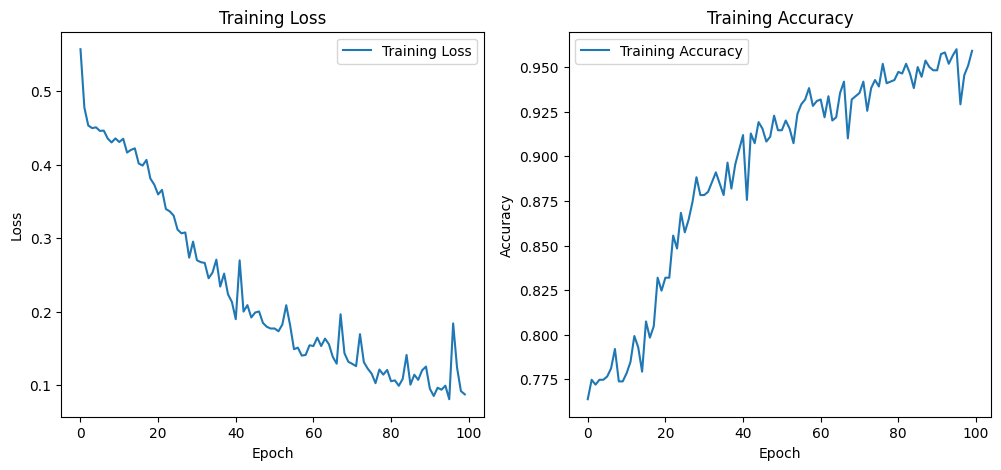

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
y_pred_probs, y_pred, y_true = [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        y_pred_probs.extend(probabilities)

        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="binary", zero_division=0)
rec  = recall_score(y_true, y_pred, average="binary", zero_division=0)
f1   = f1_score(y_true, y_pred, average="binary", zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")


Accuracy : 0.8503
Precision: 0.8883
Recall   : 0.9227
F1 Score : 0.9052


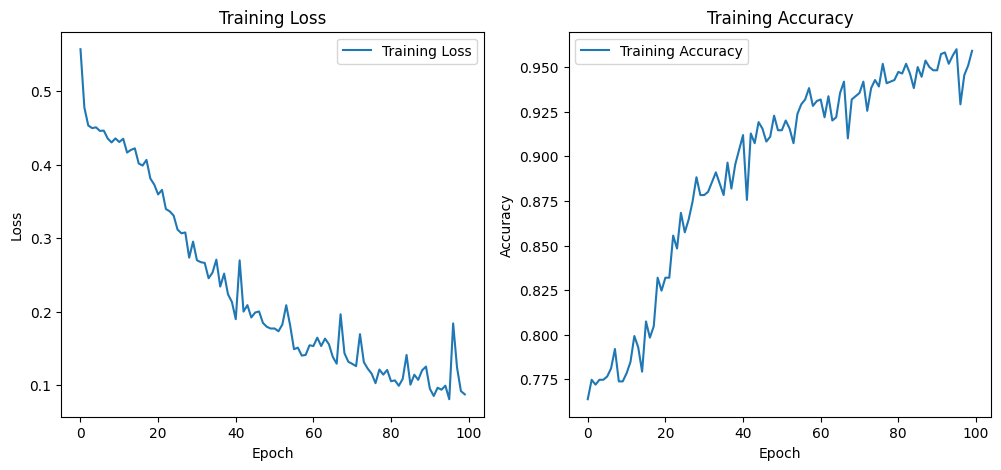

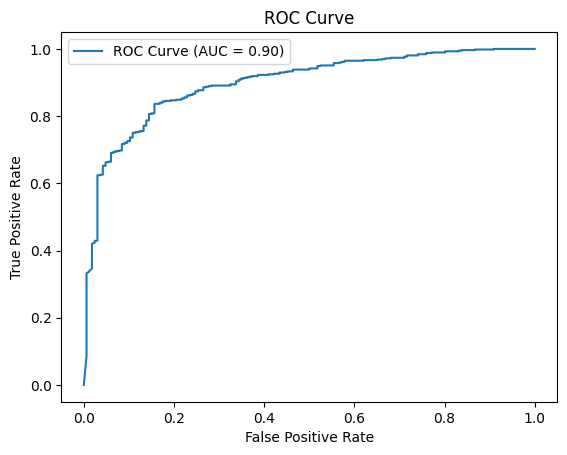

In [12]:
### 6. Plot Training Metrics ###
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()

### 7. ROC Curve ###
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()


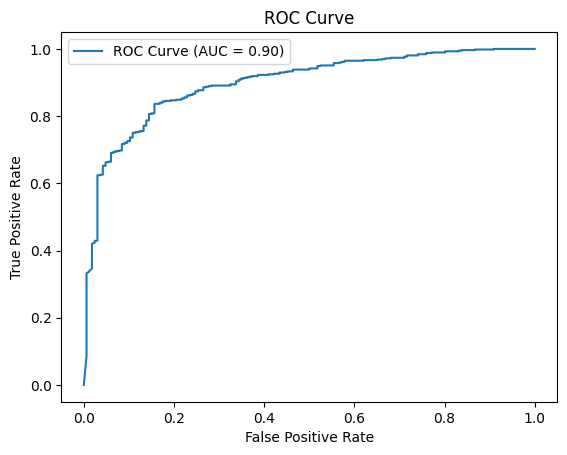

Model saved successfully!


In [13]:
# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

### 7. Save the Model ###
torch.save(model.state_dict(), "cnn_lstm_fall_detection.pth")
print("Model saved successfully!")


In [17]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        vibration_input_dim: int = 3,
        mid_channels: int = 128,
        num_classes: int = 1,       
        vib_griffin_layers: int = 2,
        vib_window: int = 16,
        p_dropout: float = 0.2,
        use_sigmoid: bool = True      
    ):
        super().__init__()
        self.num_classes = num_classes
        self.use_sigmoid = (num_classes == 1) and use_sigmoid

        self.vibration_cnn = nn.Sequential(
            LSK1D(vibration_input_dim, 64,          ks=[3,7,15,31], stride=2),
            LSK1D(64,                   mid_channels, ks=[3,7,15,31], stride=2),
        )

        self.vibration_seq = nn.Sequential(
            *[GriffinBlock1D(mid_channels, window=vib_window) for _ in range(vib_griffin_layers)]
        )
        self.vibration_ica = InterChannelAttention1D(mid_channels)

        self.pool = AttentionModule(mid_channels)

        self.head = nn.Sequential(
            nn.Linear(mid_channels, 128),
            nn.ReLU(True),
            nn.Dropout(p_dropout),
            nn.Linear(128, num_classes)
        )

        self.act = nn.Sigmoid() if self.use_sigmoid else nn.Identity()

    def extract_embedding(self, vibration_input: torch.Tensor) -> torch.Tensor:
        v = vibration_input.transpose(1, 2)   # [B,C,T]
        v = self.vibration_cnn(v)             # [B,mid,T/4]
        v = v.transpose(1, 2)                 # [B,T/4,mid]
        v = self.vibration_seq(v)             # [B,T/4,mid]
        v = self.vibration_ica(v)             # [B,T/4,mid]
        m_vec = self.pool(v)                  # [B,mid]
        return m_vec

    def forward(self, vibration_input: torch.Tensor, return_embedding: bool = False):
        m_vec = self.extract_embedding(vibration_input)    # [B, mid]
        logits = self.head(m_vec)                          # [B, 1 or C]
        out = self.act(logits)
        return (out, m_vec) if return_embedding else out


In [46]:
# Define model parameters
input_size = len(features)
hidden_size = 128
num_layers = 2
num_classes = 2

# Initialize model
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)


In [18]:
model.eval()
y_pred_probs, y_pred, y_true = [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        y_pred_probs.extend(probabilities)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())


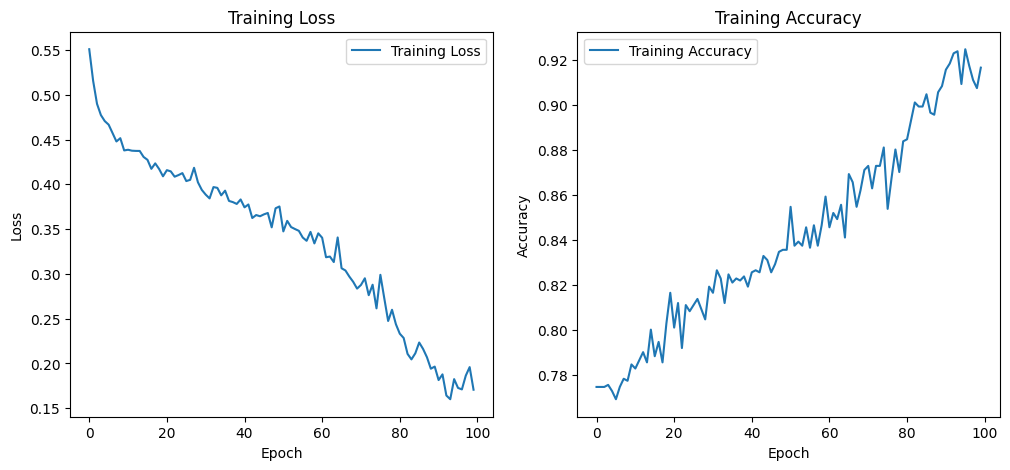

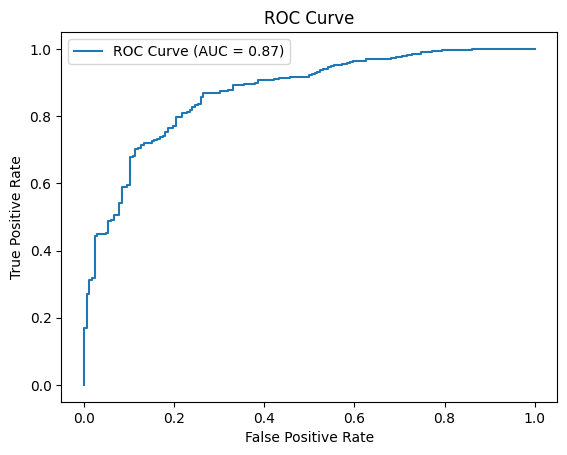

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()

### 6. ROC Curve ###
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self,
                 radar_input_dim: int = 3,
                 vibration_input_dim: int = 3,
                 mid_channels: int = 128,
                 num_classes: int = 1,
                 vib_griffin_layers: int = 2,
                 mlb_k: int = 64,
                 diffusion_timesteps: int = 1000):
        super().__init__()

        # Radar CNN backbone
        self.radar_cnn = nn.Sequential(
            LSK1D(radar_input_dim, 64, ks=[3,7,15,31], stride=2),
            LSK1D(64, mid_channels, ks=[3,7,15,31], stride=2),
        )
        self.radar_seq = Mamba2Block1D(mid_channels)

        # Vibration CNN backbone
        self.vibration_cnn = nn.Sequential(
            LSK1D(vibration_input_dim, 64, ks=[3,7,15,31], stride=2),
            LSK1D(64, mid_channels, ks=[3,7,15,31], stride=2),
        )
        self.vibration_seq = nn.Sequential(
            *[GriffinBlock1D(mid_channels, window=16) for _ in range(vib_griffin_layers)]
        )

        # 替换 attention pooling -> GAP
        self.pool_r = nn.AdaptiveAvgPool1d(1)
        self.pool_v = nn.AdaptiveAvgPool1d(1)

        # Fusion: MLB (仍保留) + Linear
        self.mlb = LowRankBilinearFusion(d_model=mid_channels, k=mlb_k)
        self.fuse_ffn = nn.Sequential(
            nn.LayerNorm(mid_channels),
            nn.Linear(mid_channels, mid_channels),
            nn.ReLU(True)
        )

        # Classifier head
        self.fusion_head = nn.Sequential(
            nn.Linear(mid_channels, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        self.use_sigmoid = (num_classes == 1)
        self.act = nn.Sigmoid() if self.use_sigmoid else nn.Identity()

        # Diffusion head
        self.diff_head = DiffusionHead(d_model=mid_channels, t_dim=64, hidden=256,
                                       timesteps=diffusion_timesteps)

    def forward(self, radar_input, vibration_input, use_diffusion: bool = False):
        # Radar
        r = radar_input.transpose(1, 2)
        r = self.radar_cnn(r)      # [B,C,T]
        r = r.transpose(1, 2)      # [B,T,C]
        r = self.radar_seq(r)

        # Vibration
        v = vibration_input.transpose(1, 2)
        v = self.vibration_cnn(v)
        v = v.transpose(1, 2)
        v = self.vibration_seq(v)

        # Pool (GAP)
        r_vec = self.pool_r(r.transpose(1,2)).squeeze(-1)  # [B,C]
        v_vec = self.pool_v(v.transpose(1,2)).squeeze(-1)

        # Fusion
        m_vec = self.mlb(r_vec, v_vec)
        m_vec = self.fuse_ffn(m_vec)

        # Classifier
        logits = self.fusion_head(m_vec)
        out = self.act(logits)

        if use_diffusion:
            with torch.no_grad():
                eps_pred, eps = self.diff_head(m_vec.detach())
            diff_loss = F.mse_loss(eps_pred, eps)
            return out, diff_loss
        else:
            return out, None


In [47]:

# Define model parameters
input_size = len(features)
num_heads = 4
hidden_size = 128
num_layers = 2
num_classes = 2

# Initialize model
model = TransformerModel(input_size, num_heads, hidden_size, num_layers, num_classes).to(device)


In [23]:
model.eval()
y_pred_probs, y_pred, y_true = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)  # [B, C]

        if outputs.shape[1] == 2:
            probs = torch.softmax(outputs, dim=1)[:, 1]
        else: 
            probs = torch.sigmoid(outputs.squeeze(1))

        probabilities = probs.cpu().numpy()
        y_pred_probs.extend(probabilities)

        _, predicted = torch.max(outputs, 1) if outputs.shape[1] > 1 else (probs >= 0.5).long()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="binary", zero_division=0)
rec  = recall_score(y_true, y_pred, average="binary", zero_division=0)
f1   = f1_score(y_true, y_pred, average="binary", zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

Accuracy : 0.7959
Precision: 0.8463
Recall   : 0.8998
F1 Score : 0.8722


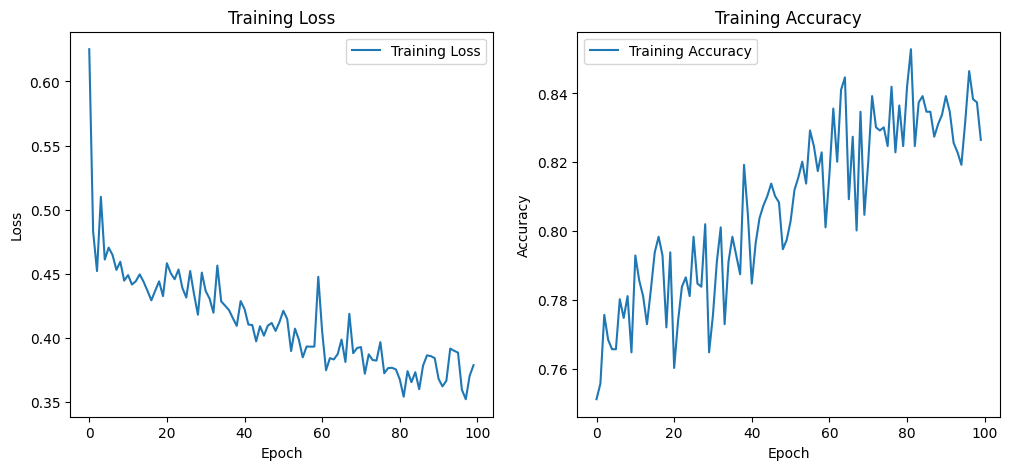

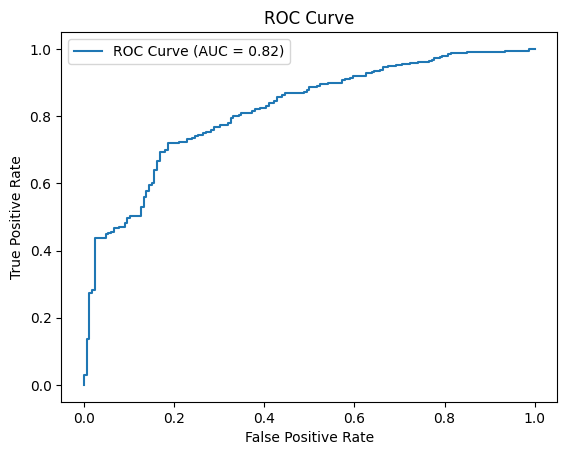

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()

### 6. ROC Curve ###
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

In [49]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttnPool1D(nn.Module):
    def __init__(self, d, hidden=128):
        super().__init__()
        self.att = nn.Sequential(
            nn.Linear(d, hidden), nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x, mask=None):
        w = self.att(x).squeeze(-1)                 # [B,T]
        if mask is not None:
            w = w.masked_fill(mask, float('-inf'))
        w = torch.softmax(w, dim=-1)                # [B,T]
        return torch.bmm(w.unsqueeze(1), x).squeeze(1)  # [B,1,T]@[B,T,D]->[B,D]


class ConvStem1D(nn.Module):
    def __init__(self, c_in: int, d_model: int, k1=7, k2=3, dropout=0.0):
        super().__init__()
        h = max(64, d_model // 2)
        self.net = nn.Sequential(
            nn.Conv1d(c_in, h, kernel_size=k1, padding=k1//2, bias=False),
            nn.GELU(),
            nn.Conv1d(h, d_model, kernel_size=k2, padding=k2//2, groups=max(1, h//2), bias=False),
            nn.BatchNorm1d(d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # x: [B,T,C] -> [B,C,T] -> conv -> [B,D,T] -> [B,T,D]
        x = x.transpose(1, 2)
        x = self.net(x)
        return x.transpose(1, 2)

class MambaLike1D(nn.Module):
    def __init__(self, d_model: int, kernel_size: int = 7, dropout: float = 0.0):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.proj_in = nn.Linear(d_model, 2 * d_model, bias=False)   # for GLU
        self.dwconv = nn.Conv1d(d_model, d_model, kernel_size=kernel_size,
                                padding=kernel_size-1, groups=d_model, bias=False)
        self.pw = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [B,T,D]
        h = self.norm(x)
        h = self.proj_in(h)                       # [B,T,2D]
        a, b = torch.chunk(h, 2, dim=-1)
        h = a * torch.sigmoid(b)                  # GLU, [B,T,D]
        h = h.transpose(1, 2)                     # -> [B,D,T]
        h = self.dwconv(h)                        # depthwise
        h = h[:, :, :x.size(1)]                
        h = h.transpose(1, 2)                     # -> [B,T,D]
        h = self.pw(h)
        h = self.dropout(h)
        return x + h                         
        
class SoftMoE(nn.Module):
    def __init__(self, d_model: int, hidden_mult: int = 4, num_experts: int = 4, dropout: float = 0.1):
        super().__init__()
        self.num_experts = num_experts
        inner = hidden_mult * d_model

        self.router = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_experts, bias=False)
        )
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, inner, bias=False),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(inner, d_model, bias=False)
            ) for _ in range(num_experts)
        ])
        self.out_drop = nn.Dropout(dropout)

    def forward(self, x):
        # x: [B,T,D]
        logits = self.router(x)                  # [B,T,E]
        weights = torch.softmax(logits, dim=-1)  # soft routing
        y_sum = 0.0
        for e_idx, expert in enumerate(self.experts):
            y_e = expert(x)                      # [B,T,D]
            w_e = weights[..., e_idx].unsqueeze(-1)  # [B,T,1]
            y_sum = y_sum + w_e * y_e
        return self.out_drop(y_sum)

class HybridEncoderBlock(nn.Module):
    def __init__(
        self,
        d_model: int,
        nhead: int,
        ffn_mult: int = 4,
        dropout: float = 0.1,
        use_moe: bool = False,
        moe_num_experts: int = 4,
        use_mamba: bool = False,
    ):
        super().__init__()
        self.use_moe = use_moe
        self.use_mamba = use_mamba

        self.attn_norm = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.attn_drop = nn.Dropout(dropout)
        if use_moe:
            self.ff = SoftMoE(d_model, hidden_mult=ffn_mult, num_experts=moe_num_experts, dropout=dropout)
        else:
            inner = ffn_mult * d_model
            self.ff = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, inner, bias=False),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(inner, d_model, bias=False),
                nn.Dropout(dropout),
            )

        # Mamba-like
        if use_mamba:
            self.mamba = MambaLike1D(d_model, kernel_size=7, dropout=dropout)

    def forward(self, x, key_padding_mask=None):
        # MHSA
        h = self.attn_norm(x)
        attn_out, _ = self.attn(h, h, h, key_padding_mask=key_padding_mask, need_weights=False)
        x = x + self.attn_drop(attn_out)
        x = x + self.ff(x)
        if self.use_mamba:
            x = self.mamba(x)
        return x

class LSTM_Transformer(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        num_heads,
        num_classes,
        bidirectional=False,
        dropout=0.3,
        use_posenc=True,
        use_cnn_stem: bool = True,
        use_moe: bool = True,
        moe_num_experts: int = 4,
        use_mamba: bool = True,
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.d_model = hidden_size  # Transformer d_model
        self.use_posenc = use_posenc
        self.use_cnn_stem = use_cnn_stem

        if use_cnn_stem:
            self.cnn_stem = ConvStem1D(c_in=input_size, d_model=hidden_size, dropout=dropout)
            lstm_input_size = hidden_size
        else:
            self.cnn_stem = None
            lstm_input_size = input_size

        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )

        lstm_out_dim = hidden_size * (2 if bidirectional else 1)
        self.proj = nn.Identity() if lstm_out_dim == self.d_model else nn.Linear(lstm_out_dim, self.d_model, bias=False)

        if use_posenc:
            self.pos_enc = nn.Parameter(torch.zeros(1, 4096, self.d_model)) 

        self.pre_norm = nn.LayerNorm(self.d_model)

        self.encoder_layers = nn.ModuleList([
            HybridEncoderBlock(
                d_model=self.d_model,
                nhead=num_heads,
                ffn_mult=4,
                dropout=dropout,
                use_moe=use_moe,
                moe_num_experts=moe_num_experts,
                use_mamba=use_mamba,
            ) for _ in range(num_layers)
        ])

        self.pool = AttnPool1D(self.d_model, hidden=min(128, self.d_model))
        self.head = nn.Sequential(
            nn.LayerNorm(self.d_model),
            nn.Dropout(dropout),
            nn.Linear(self.d_model, self.d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(self.d_model // 2, num_classes)
        )

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, lengths=None):
        B, T, _ = x.shape

        pad_mask = None
        if lengths is not None:
            device = x.device
            lengths = torch.as_tensor(lengths, device=device)
            arange = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
            pad_mask = arange >= lengths.unsqueeze(1)   # [B,T] True=pad

        if self.use_cnn_stem:
            x = self.cnn_stem(x)               # [B,T,H]

        # LSTM
        lstm_out, _ = self.lstm(x)             # [B,T,H] or [B,T,2H]
        h = self.proj(lstm_out)                # [B,T,D]
        h = self.pre_norm(h)

        if self.use_posenc:
            h = h + self.pos_enc[:, :T, :]

        for blk in self.encoder_layers:
            h = blk(h, key_padding_mask=pad_mask)   # [B,T,D]

        feat = self.pool(h, mask=pad_mask)      # [B,D]

        logits = self.head(feat)                # [B,C]
        return logits


In [48]:
# Define model parameters
input_size = len(features)
hidden_size = 128
num_layers = 2
num_heads = 4
num_classes = 2

# Initialize model
model = LSTM_Transformer(input_size, hidden_size, num_layers, num_heads, num_classes).to(device)


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
y_pred_probs, y_pred, y_true = [], [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        y_pred_probs.extend(probabilities)

        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="binary", zero_division=0)
rec  = recall_score(y_true, y_pred, average="binary", zero_division=0)
f1   = f1_score(y_true, y_pred, average="binary", zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")


Accuracy : 0.8286
Precision: 0.8934
Recall   : 0.8840
F1 Score : 0.8887


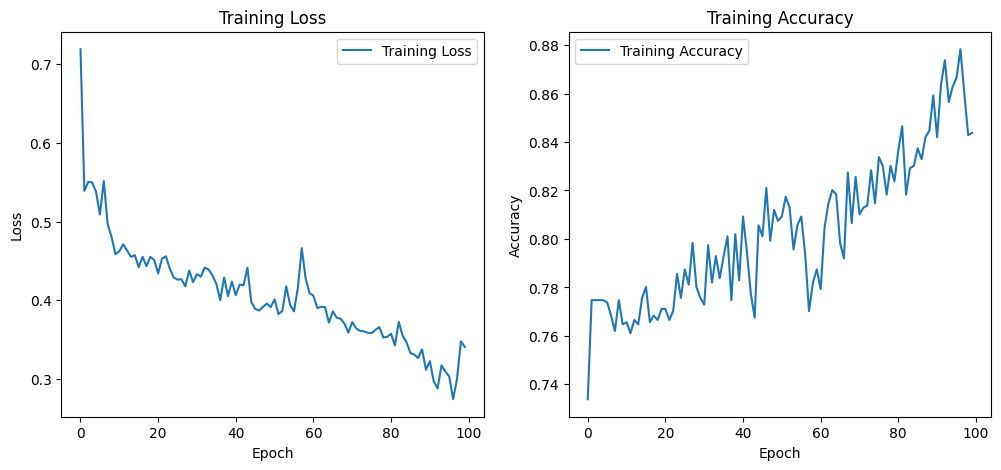

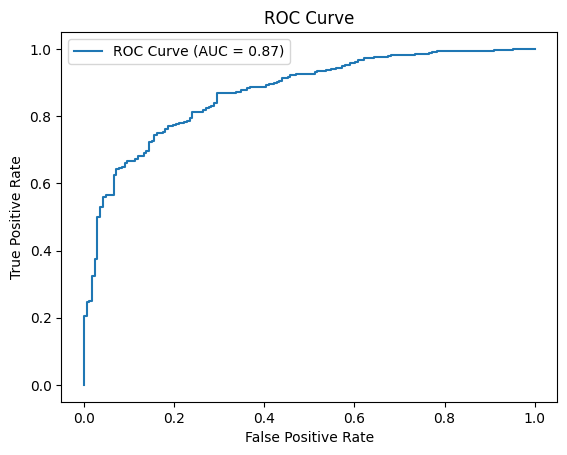

In [30]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

In [31]:
import torch, os
print("PyTorch:", torch.__version__, "| CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch: 2.5.1+cu121 | CUDA: 12.1
CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualFFN1D(nn.Module):

    def __init__(self, d_model: int, mult: int = 4, dropout: float = 0.1):
        super().__init__()
        hidden = d_model * mult
        self.is_seq = True  
        self.net = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, hidden, bias=False),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, d_model, bias=False),
        )
        self.out_norm = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 2:  # [B,D]
            y = x + self.net(x)
            return self.out_norm(y)
        elif x.dim() == 3:  # [B,T,D]
            B,T,D = x.shape
            x2 = x.reshape(B*T, D)
            y2 = x2 + self.net(x2)
            y  = y2.reshape(B, T, D)
            return self.out_norm(y)
        else:
            raise ValueError(f"ResidualFFN1D expects [B,D] or [B,T,D], got {x.shape}")

class MultimodalP2MFDS_NoMoE(nn.Module):
    def __init__(self,
                 radar_input_dim: int = 3,
                 vibration_input_dim: int = 3,
                 mid_channels: int = 128,
                 num_classes: int = 1,
                 ffn_mult: int = 4,
                 ffn_dropout: float = 0.1,
                 vib_griffin_layers: int = 2,
                 vib_window: int = 16,
                 fusion_heads: int = 4,
                 mlb_k: int = 64,
                 diffusion_timesteps: int = 1000):
        super().__init__()

        # ----- Radar -----
        self.radar_cnn = nn.Sequential(
            LSK1D(radar_input_dim, 64,  ks=[3,7,15,31], stride=2),
            LSK1D(64,               mid_channels,        ks=[3,7,15,31], stride=2),
        )
        self.radar_seq   = Mamba2Block1D(mid_channels)
        self.radar_ffn   = ResidualFFN1D(mid_channels, mult=ffn_mult, dropout=ffn_dropout)  # 替代 radar_moe

        # ----- Vibration -----
        self.vibration_cnn = nn.Sequential(
            LSK1D(vibration_input_dim, 64,  ks=[3,7,15,31], stride=2),
            LSK1D(64,                 mid_channels,        ks=[3,7,15,31], stride=2),
        )
        self.vibration_seq = nn.Sequential(
            *[GriffinBlock1D(mid_channels, window=vib_window) for _ in range(vib_griffin_layers)]
        )
        self.vibration_ica = InterChannelAttention1D(mid_channels)

        self.ca_r_from_v = CrossAttentionBlock(mid_channels, nhead=fusion_heads)
        self.ca_v_from_r = CrossAttentionBlock(mid_channels, nhead=fusion_heads)
        self.pool_r = AttentionModule(mid_channels)
        self.pool_v = AttentionModule(mid_channels)

        self.mlb      = LowRankBilinearFusion(d_model=mid_channels, k=mlb_k)
        self.fuse_ffn = ResidualFFN1D(mid_channels, mult=ffn_mult, dropout=ffn_dropout)

        self.fusion_head = nn.Sequential(
            nn.Linear(mid_channels, 128), nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        self.use_sigmoid = (num_classes == 1)  
        self.act = nn.Sigmoid() if self.use_sigmoid else nn.Identity()

        # ----- Optional diffusion head on m_vec -----
        self.diff_head = DiffusionHead(d_model=mid_channels, t_dim=64, hidden=256,
                                       timesteps=diffusion_timesteps)

    def radar_moe_aux(self) -> torch.Tensor:
        return torch.tensor(0.0, device=next(self.parameters()).device)

    def fuse_moe_aux(self) -> torch.Tensor:
        return torch.tensor(0.0, device=next(self.parameters()).device)

    def forward(self,
                radar_input: torch.Tensor,
                vibration_input: torch.Tensor,
                use_diffusion: bool = False):
        # ----- Radar path -----
        r = radar_input.transpose(1, 2)      # [B,C,T] for Conv1d
        r = self.radar_cnn(r)                # [B,128,T/4]
        r = r.transpose(1, 2)                # [B,T/4,128]
        r = self.radar_seq(r)
        r = self.radar_ffn(r)                # <- 无 MoE

        # ----- Vibration path -----
        v = vibration_input.transpose(1, 2)
        v = self.vibration_cnn(v)            # [B,128,T/4]
        v = v.transpose(1, 2)                # [B,T/4,128]
        v = self.vibration_seq(v)
        v = self.vibration_ica(v)

        # ----- Cross-modal -----
        r_enh = self.ca_r_from_v(r, v)       # r <- v
        v_enh = self.ca_v_from_r(v, r)       # v <- r

        # ----- Pooling -----
        r_vec = self.pool_r(r_enh)           # [B,128]
        v_vec = self.pool_v(v_enh)           # [B,128]

        # ----- Fusion -----
        m_vec = self.mlb(r_vec, v_vec)       # [B,128]
        m_vec = self.fuse_ffn(m_vec)         # <- 无 MoE

        # ----- Classifier -----
        logits = self.fusion_head(m_vec)     # [B,1] or [B,C]
        out = self.act(logits)             

        if use_diffusion:
            with torch.no_grad():        
                eps_pred, eps = self.diff_head(m_vec.detach())
            diff_loss = F.mse_loss(eps_pred, eps)
            return out, diff_loss
        else:
            return out, None


In [33]:
# Define model parameters
input_size = len(features)
hidden_size = 256
num_layers = 2
num_heads = 8
num_classes = 2

# Initialize model
model = LSTM_Transformer_Pro(input_size, hidden_size, num_layers, num_heads, num_classes).to(device)

C:\Users\yiren\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [35]:
import os
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()
torch.backends.cudnn.benchmark = True

base_dataset = train_loader.dataset  

def try_get_labels(ds):
    for attr in ["targets", "labels", "y"]:
        if hasattr(ds, attr):
            arr = getattr(ds, attr)
            return np.asarray(arr) if not isinstance(arr, np.ndarray) else arr
    ys = []
    try:
        for i in range(len(ds)):
            item = ds[i]
            if isinstance(item, (list, tuple)) and len(item) >= 2:
                ys.append(int(item[1]))
            else:
                return None
        return np.asarray(ys)
    except Exception:
        return None

labels = try_get_labels(base_dataset)
n_total = len(base_dataset)
indices = np.arange(n_total)

n_splits = 8
groups = []
if labels is not None:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for _, test_idx in skf.split(indices, labels):
        groups.append(test_idx)
else:
    groups = np.array_split(indices, n_splits)

@torch.inference_mode()
def evaluate_subset(subset):
    loader = DataLoader(
        subset,
        batch_size=256,
        shuffle=False,
        num_workers=0,                 
        pin_memory=torch.cuda.is_available()
    )
    all_preds, all_labels = [], []
    for bi, batch in enumerate(loader):
        try:
            if isinstance(batch, (list, tuple)):
                xb, yb = batch[0], batch[1]
                extra = batch[2:] if len(batch) > 2 else None
            elif isinstance(batch, dict):
                xb, yb = batch["x"], batch["y"]
                extra = batch.get("lengths", None)
            else:
                raise RuntimeError(f"Unknown batch type: {type(batch)}")

            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            logits = model(xb)
            pred = torch.argmax(logits, dim=1)

            all_preds.extend(pred.detach().cpu().numpy())
            all_labels.extend(yb.detach().cpu().numpy())
        except Exception as e:
            print(f"[evaluate_subset] Error at batch {bi}, batch type={type(batch)}")
            raise

    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    rec  = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    f1   = f1_score(all_labels, all_preds, average="binary", zero_division=0)
    return acc, prec, rec, f1, len(all_labels)

# === 逐组评估 ===
results = []
for k, idx in enumerate(groups, start=1):
    subset = Subset(base_dataset, idx)
    acc, prec, rec, f1, n = evaluate_subset(subset)
    results.append((k, n, acc, prec, rec, f1))
    print(f"[Group {k}/8] N={n:4d} | Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

# === 汇总 ===
if results:
    mean_acc  = np.mean([r[2] for r in results])
    mean_prec = np.mean([r[3] for r in results])
    mean_rec  = np.mean([r[4] for r in results])
    mean_f1   = np.mean([r[5] for r in results])

    Ns = np.array([r[1] for r in results], dtype=float)
    w  = Ns / Ns.sum()
    w_acc  = np.sum(w * np.array([r[2] for r in results]))
    w_prec = np.sum(w * np.array([r[3] for r in results]))
    w_rec  = np.sum(w * np.array([r[4] for r in results]))
    w_f1   = np.sum(w * np.array([r[5] for r in results]))

    print("\n=== Overall (simple mean over 8 groups) ===")
    print(f"Acc={mean_acc:.4f} | Prec={mean_prec:.4f} | Rec={mean_rec:.4f} | F1={mean_f1:.4f}")

    print("=== Overall (sample-weighted mean) ===")
    print(f"Acc={w_acc:.4f} | Prec={w_prec:.4f} | Rec={w_rec:.4f} | F1={w_f1:.4f}")


[Group 1/8] N= 138 | Acc=0.7826 | Prec=0.8235 | Rec=0.9159 | F1=0.8673
[Group 2/8] N= 138 | Acc=0.8333 | Prec=0.8231 | Rec=1.0000 | F1=0.9030
[Group 3/8] N= 138 | Acc=0.8188 | Prec=0.8203 | Rec=0.9813 | F1=0.8936
[Group 4/8] N= 138 | Acc=0.8116 | Prec=0.8293 | Rec=0.9533 | F1=0.8870
[Group 5/8] N= 138 | Acc=0.8043 | Prec=0.8175 | Rec=0.9626 | F1=0.8841
[Group 6/8] N= 137 | Acc=0.8686 | Prec=0.8729 | Rec=0.9717 | F1=0.9196
[Group 7/8] N= 137 | Acc=0.8540 | Prec=0.8525 | Rec=0.9811 | F1=0.9123
[Group 8/8] N= 137 | Acc=0.8321 | Prec=0.8374 | Rec=0.9717 | F1=0.8996

=== Overall (simple mean over 8 groups) ===
Acc=0.8257 | Prec=0.8345 | Rec=0.9672 | F1=0.8958
=== Overall (sample-weighted mean) ===
Acc=0.8256 | Prec=0.8345 | Rec=0.9672 | F1=0.8958


In [36]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import itertools
import os
from scipy.interpolate import make_interp_spline

@torch.inference_mode()
def evaluate_subset(subset):
    loader = DataLoader(
        subset,
        batch_size=256,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    all_preds, all_labels, all_scores = [], [], []
    for bi, batch in enumerate(loader):
        try:
            if isinstance(batch, (list, tuple)):
                xb, yb = batch[0], batch[1]
                extra = batch[2:] if len(batch) > 2 else None
            elif isinstance(batch, dict):
                xb, yb = batch["x"], batch["y"]
                extra = batch.get("lengths", None)
            else:
                raise RuntimeError(f"Unknown batch type: {type(batch)}")

            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            logits = model(xb)                      # [B, C]
            if logits.shape[1] == 1:
                probs_pos = torch.sigmoid(logits.squeeze(1))       # [B]
                pred = (probs_pos >= 0.5).long()
            else:
                probs = torch.softmax(logits, dim=1)               # [B, 2]
                probs_pos = probs[:, 1]                            
                pred = torch.argmax(logits, dim=1)

            all_scores.extend(probs_pos.detach().cpu().numpy())
            all_preds.extend(pred.detach().cpu().numpy())
            all_labels.extend(yb.detach().cpu().numpy())

        except Exception as e:
            print(f"[evaluate_subset] Error at batch {bi}, batch type={type(batch)}")
            raise

    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    rec  = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    f1   = f1_score(all_labels, all_preds, average="binary", zero_division=0)
    return acc, prec, rec, f1, len(all_labels), np.asarray(all_labels), np.asarray(all_scores), np.asarray(all_preds)

results = []
roc_data, pr_data, cms = [], [], []
os.makedirs("figs_by_group", exist_ok=True)

for k, idx in enumerate(groups, start=1):
    subset = Subset(base_dataset, idx)
    acc, prec, rec, f1, n, y_true, y_score, y_pred = evaluate_subset(subset)
    results.append((k, n, acc, prec, rec, f1))
    print(f"[Group {k}/8] N={n:4d} | Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    cms.append((k, cm))

    if len(np.unique(y_true)) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
        roc_auc = auc(fpr, tpr)
        roc_data.append((k, fpr, tpr, roc_auc))

        prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_score, pos_label=1)
        ap = average_precision_score(y_true, y_score, pos_label=1)
        pr_data.append((k, rec_curve, prec_curve, ap))

if results:
    mean_acc  = np.mean([r[2] for r in results])
    mean_prec = np.mean([r[3] for r in results])
    mean_rec  = np.mean([r[4] for r in results])
    mean_f1   = np.mean([r[5] for r in results])

    Ns = np.array([r[1] for r in results], dtype=float)
    w  = Ns / Ns.sum()
    w_acc  = np.sum(w * np.array([r[2] for r in results]))
    w_prec = np.sum(w * np.array([r[3] for r in results]))
    w_rec  = np.sum(w * np.array([r[4] for r in results]))
    w_f1   = np.sum(w * np.array([r[5] for r in results]))

    print("\n=== Overall (simple mean over 8 groups) ===")
    print(f"Acc={mean_acc:.4f} | Prec={mean_prec:.4f} | Rec={mean_rec:.4f} | F1={mean_f1:.4f}")

    print("=== Overall (sample-weighted mean) ===")
    print(f"Acc={w_acc:.4f} | Prec={w_prec:.4f} | Rec={w_rec:.4f} | F1={w_f1:.4f}")

if len(roc_data) > 0:
    plt.figure(figsize=(8, 7))

    colors = plt.cm.tab10.colors  
    for i, (k, fpr, tpr, roc_auc) in enumerate(roc_data):
        plt.plot(
            fpr, tpr, color=colors[i % len(colors)],
            lw=2, alpha=0.9,
            label=f"Group {k} (AUC={roc_auc:.3f})"
        )

    plt.plot([0, 1], [0, 1], linestyle="--", lw=1.5, color="gray", alpha=0.7)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("ROC Curves by Group", fontsize=16, weight="bold")

    plt.legend(loc="lower right", fontsize=10, frameon=True, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.savefig("figs_by_group/roc_by_group_beauty.png", dpi=300)
    plt.close()
    print("Saved: figs_by_group/roc_by_group_beauty.png")

if len(pr_data) > 0:
    plt.figure(figsize=(7, 6))
    for k, rec_curve, prec_curve, ap in pr_data:
        plt.plot(rec_curve, prec_curve, lw=1.5, label=f"Group {k} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves by Group")
    plt.legend(loc="lower left", fontsize=8)
    plt.tight_layout()
    plt.savefig("figs_by_group/pr_by_group.png", dpi=200)
    plt.close()
    print("Saved: figs_by_group/pr_by_group.png")

def plot_cm(cm, title, save_path):
    plt.figure(figsize=(4, 3.6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["0", "1"])
    plt.yticks(tick_marks, ["0", "1"])
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.close()

for k, cm in cms:
    outp = f"figs_by_group/cm_group_{k}.png"
    plot_cm(cm, f"Confusion Matrix - Group {k}", outp)
    print(f"Saved: {outp}")

[Group 1/8] N= 138 | Acc=0.7826 | Prec=0.8235 | Rec=0.9159 | F1=0.8673
[Group 2/8] N= 138 | Acc=0.8333 | Prec=0.8231 | Rec=1.0000 | F1=0.9030
[Group 3/8] N= 138 | Acc=0.8188 | Prec=0.8203 | Rec=0.9813 | F1=0.8936
[Group 4/8] N= 138 | Acc=0.8116 | Prec=0.8293 | Rec=0.9533 | F1=0.8870
[Group 5/8] N= 138 | Acc=0.8043 | Prec=0.8175 | Rec=0.9626 | F1=0.8841
[Group 6/8] N= 137 | Acc=0.8686 | Prec=0.8729 | Rec=0.9717 | F1=0.9196
[Group 7/8] N= 137 | Acc=0.8540 | Prec=0.8525 | Rec=0.9811 | F1=0.9123
[Group 8/8] N= 137 | Acc=0.8321 | Prec=0.8374 | Rec=0.9717 | F1=0.8996

=== Overall (simple mean over 8 groups) ===
Acc=0.8257 | Prec=0.8345 | Rec=0.9672 | F1=0.8958
=== Overall (sample-weighted mean) ===
Acc=0.8256 | Prec=0.8345 | Rec=0.9672 | F1=0.8958
Saved: figs_by_group/roc_by_group_beauty.png
Saved: figs_by_group/pr_by_group.png
Saved: figs_by_group/cm_group_1.png
Saved: figs_by_group/cm_group_2.png
Saved: figs_by_group/cm_group_3.png
Saved: figs_by_group/cm_group_4.png
Saved: figs_by_group/c

In [37]:


from typing import List, Tuple, Optional
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionModule(nn.Module):
    def __init__(self, input_dim: int, hidden: int = 64):
        super().__init__()
        self.att = nn.Sequential(nn.Linear(input_dim, hidden), nn.Tanh(), nn.Linear(hidden, 1))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        w = torch.softmax(self.att(x), dim=1)
        return torch.sum(x * w, dim=1)

class InterChannelAttention1D(nn.Module):
    def __init__(self, channels: int, proj: bool = True):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
        self.proj = nn.Linear(channels, channels, bias=False) if proj else nn.Identity()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.norm(x)                                  # [B,T,C]
        B, T, C = z.shape
        A = torch.matmul(z.transpose(1, 2), z) / max(1,T) # [B,C,C]
        A = torch.softmax(A / (C ** 0.5), dim=-1)
        y = torch.matmul(z, A)                            # [B,T,C]
        return self.proj(y) + x

class LSK1D(nn.Module):
    def __init__(self, c_in: int, c_out: int, ks: List[int] = [3,7,15,31], stride: int = 2):
        super().__init__()
        self.proj = nn.Conv1d(c_in, c_out, 1, bias=False)
        self.branches = nn.ModuleList([nn.Conv1d(c_out, c_out, k, padding=k//2, groups=c_out, bias=False) for k in ks])
        self.fuse = nn.Conv1d(c_out * len(ks), c_out, 1, bias=False)
        self.pool = nn.AdaptiveAvgPool1d(1)
        hidden = max(4, c_out // 8)
        self.gate = nn.Sequential(nn.Conv1d(c_out, hidden, 1), nn.ReLU(True), nn.Conv1d(hidden, len(ks), 1))
        self.down = nn.AvgPool1d(2, stride=stride, ceil_mode=True) if stride>1 else nn.Identity()
        self.bn = nn.BatchNorm1d(c_out)
        self.act = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        feats = [br(x) for br in self.branches]
        cat = torch.cat(feats, dim=1)
        fused = self.fuse(cat)
        alpha = torch.softmax(self.gate(self.pool(fused)).squeeze(-1), dim=-1)  # [B,S]
        out = 0
        for i, f in enumerate(feats):
            out = out + alpha[:, i].view(-1,1,1) * f
        out = self.act(self.bn(out))
        return self.down(out)

class Mamba2Block1D(nn.Module):
    def __init__(self, d_model: int, kernel_size: int = 5):
        super().__init__()
        self.in_proj = nn.Linear(d_model, d_model*2, bias=False)
        self.dw_conv = nn.Conv1d(d_model, d_model, kernel_size, padding=kernel_size//2, groups=d_model)
        self.a = nn.Parameter(torch.zeros(d_model))
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        B,T,D = x.shape
        gate, val = self.in_proj(x).chunk(2, dim=-1)
        g = torch.sigmoid(gate)
        v = self.dw_conv(val.transpose(1,2)).transpose(1,2)
        a = torch.tanh(self.a)
        h = torch.zeros(B, D, device=x.device, dtype=x.dtype)
        y = torch.zeros_like(v)
        for t in range(T):
            h = a*h + g[:,t,:]*v[:,t,:]
            y[:,t,:] = h
        return self.norm(x + self.out_proj(y))

class ExpertFFN(nn.Module):
    def __init__(self, d_model: int, hidden: int = 256):
        super().__init__()
        self.net = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, hidden), nn.GELU(), nn.Linear(hidden, d_model))
    def forward(self, x): return self.net(x)

class SwitchMoE(nn.Module):
    def __init__(self, d_model: int, n_experts: int = 4, hidden: int = 256, dropout: float = 0.0):
        super().__init__()
        self.experts = nn.ModuleList([ExpertFFN(d_model, hidden) for _ in range(n_experts)])
        self.gate = nn.Linear(d_model, n_experts, bias=False)
        self.drop = nn.Dropout(dropout)
        self._aux_loss = torch.tensor(0.0)
    @torch.no_grad()
    def _lb(self, gates_softmax, top1_idx, eps=1e-9):
        N,E = gates_softmax.shape
        importance = gates_softmax.sum(dim=0)/(N+eps)
        load = torch.zeros(E, device=gates_softmax.device, dtype=gates_softmax.dtype)
        load.scatter_add_(0, top1_idx, torch.ones_like(top1_idx, dtype=gates_softmax.dtype))
        load = load/(N+eps)
        return E * (importance * load).sum()
    def forward(self, x):  # [B,T,D]
        B,T,D = x.shape
        xt = x.reshape(B*T, D)
        logits = self.gate(xt)
        gates = torch.softmax(logits, dim=-1)
        top1 = torch.argmax(gates, dim=-1)
        self._aux_loss = self._lb(gates, top1)
        y = torch.zeros_like(xt)
        for e_id, expert in enumerate(self.experts):
            m = (top1 == e_id)
            if m.any(): y[m] = expert(xt[m])
        return self.drop(y).reshape(B,T,D)
    def aux_loss(self): return self._aux_loss

class GLRUCell(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        self.in_proj = nn.Linear(d_model, 2*d_model, bias=False)
        self.state_proj = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        B,T,D = x.shape
        h = torch.zeros(B, D, device=x.device, dtype=x.dtype)
        y = torch.zeros_like(x)
        for t in range(T):
            gx, vx = self.in_proj(x[:,t,:]).chunk(2, dim=-1)
            u = torch.sigmoid(gx)
            cand = self.state_proj(vx)
            h = u*h + (1-u)*cand
            y[:,t,:] = h
        return self.norm(y)

class LocalAttention1D(nn.Module):
    def __init__(self, d_model: int, heads: int = 4, window: int = 16):
        super().__init__()
        self.h, self.w = heads, window
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.proj = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        B,T,D = x.shape; H = self.h; d = D//H; w = self.w; scale = d**-0.5
        q = self.q(x).view(B,T,H,d); k = self.k(x).view(B,T,H,d); v = self.v(x).view(B,T,H,d)
        out = torch.zeros_like(q)
        for t in range(T):
            s = max(0, t-w); e = min(T, t+w+1)
            qi = q[:,t:t+1]; ki = k[:,s:e]; vi = v[:,s:e]
            attn = (qi*scale) @ ki.transpose(-2,-1)
            attn = torch.softmax(attn, dim=-1)
            out[:,t:t+1] = attn @ vi
        out = out.view(B,T,D)
        return self.norm(x + self.proj(out))

class GriffinBlock1D(nn.Module):
    def __init__(self, d_model: int, window: int = 16, ffn_mult: int = 4):
        super().__init__()
        self.glru = GLRUCell(d_model)
        self.local_attn = LocalAttention1D(d_model, heads=4, window=window)
        self.ffn = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, d_model*ffn_mult), nn.GELU(), nn.Linear(d_model*ffn_mult, d_model))
        self.out_norm = nn.LayerNorm(d_model)
    def forward(self, x):
        x = self.glru(x)
        x = self.local_attn(x)
        x = x + self.ffn(x)
        return self.out_norm(x)

class CrossAttentionBlock(nn.Module):
    def __init__(self, d_model: int, nhead: int = 4, dropout: float = 0.0):
        super().__init__()
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.proj = nn.Linear(d_model, d_model, bias=False)
        self.nhead = nhead
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model)
    def forward(self, a, b):  # a<-b
        B,T,D = a.shape; H = self.nhead; d = D//H; scale = d**-0.5
        q = self.q(a).view(B,T,H,d); k = self.k(b).view(B,T,H,d); v = self.v(b).view(B,T,H,d)
        attn = (q @ k.transpose(-2,-1)) * scale
        attn = torch.softmax(attn, dim=-1)
        out = (attn @ v).view(B,T,D)
        return self.ln(a + self.dropout(self.proj(out)))

class LowRankBilinearFusion(nn.Module):
    def __init__(self, d_model: int, k: int = 64):
        super().__init__()
        self.pr = nn.Linear(d_model, k, bias=False)
        self.pv = nn.Linear(d_model, k, bias=False)
        self.out = nn.Linear(k, d_model, bias=False)
        self.ln  = nn.LayerNorm(d_model)
    def forward(self, r_vec, v_vec):
        r = torch.tanh(self.pr(r_vec)); v = torch.tanh(self.pv(v_vec))
        return self.ln(self.out(r*v))

class FuseMoE1D(nn.Module):
    def __init__(self, d_model: int, n_experts: int = 4, hidden: int = 256, dropout: float = 0.1):
        super().__init__()
        self.moe = SwitchMoE(d_model, n_experts, hidden, dropout)
        self.ln  = nn.LayerNorm(d_model)
    def aux_loss(self): return self.moe.aux_loss()
    def forward(self, x):
        y = self.moe(x.unsqueeze(1)).squeeze(1)
        return self.ln(y + x)

def timestep_embedding(t: torch.Tensor, dim: int) -> torch.Tensor:
    device = t.device
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=device) / max(1, half-1))
    args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    if dim % 2 == 1: emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb  # [B, dim]

class CosineNoiseSchedule:
    def __init__(self, timesteps: int = 1000, s: float = 0.008):
        self.T = timesteps; self.s = s
        t = torch.linspace(0, timesteps, timesteps+1)
        alphas_cumprod = torch.cos(((t / timesteps) + s) / (1+s) * math.pi/2) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        self.alphas_cumprod = alphas_cumprod.clamp(min=1e-5, max=0.99999)

    def sample(self, t: torch.Tensor, device=None) -> Tuple[torch.Tensor, torch.Tensor]:
        if device is None: device = t.device
        ab = self.alphas_cumprod[t.long()].to(device)
        return ab, (1 - ab)

class DiffusionHead(nn.Module):
    def __init__(self, d_model: int = 128, t_dim: int = 64, hidden: int = 256, timesteps: int = 1000):
        super().__init__()
        self.timesteps = timesteps
        self.t_dim = t_dim
        self.net = nn.Sequential(
            nn.LayerNorm(d_model + t_dim),
            nn.Linear(d_model + t_dim, hidden), nn.GELU(),
            nn.Linear(hidden, d_model)
        )
        self.schedule = CosineNoiseSchedule(timesteps=timesteps)

    def forward(self, m_vec: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        B, D = m_vec.shape
        device = m_vec.device
        t = torch.randint(low=1, high=self.timesteps, size=(B,), device=device)
        alpha_bar, one_minus_alpha_bar = self.schedule.sample(t, device=device)  # [B], [B]
        alpha_bar = alpha_bar.view(B,1)
        sigma2 = one_minus_alpha_bar.view(B,1)

        eps = torch.randn_like(m_vec)                 
        m_t = torch.sqrt(alpha_bar) * m_vec + torch.sqrt(sigma2) * eps 
        t_emb = timestep_embedding(t, self.t_dim).to(device)            # [B,t_dim]
        x_in = torch.cat([m_t, t_emb], dim=-1)                           # [B,D+t_dim]
        eps_pred = self.net(x_in)                                      
        return eps_pred, eps

class modelLSTNtransformer(nn.Module):
    def __init__(self,
                 radar_input_dim: int = 3,
                 vibration_input_dim: int = 3,
                 mid_channels: int = 128,
                 num_classes: int = 1,
                 moe_experts: int = 4,
                 moe_hidden: int = 256,
                 moe_dropout: float = 0.1,
                 vib_griffin_layers: int = 2,
                 vib_window: int = 16,
                 fusion_heads: int = 4,
                 mlb_k: int = 64,
                 diffusion_timesteps: int = 1000):
        super().__init__()
        # Radar
        self.radar_cnn = nn.Sequential(
            LSK1D(radar_input_dim, 64,  ks=[3,7,15,31], stride=2),
            LSK1D(64, mid_channels, ks=[3,7,15,31], stride=2),
        )
        self.radar_seq  = Mamba2Block1D(mid_channels)
        self.radar_moe  = SwitchMoE(mid_channels, n_experts=moe_experts, hidden=moe_hidden, dropout=moe_dropout)

        # Vibration
        self.vibration_cnn = nn.Sequential(
            LSK1D(vibration_input_dim, 64,  ks=[3,7,15,31], stride=2),
            LSK1D(64,                 mid_channels, ks=[3,7,15,31], stride=2),
        )
        self.vibration_seq = nn.Sequential(*[GriffinBlock1D(mid_channels, window=vib_window) for _ in range(vib_griffin_layers)])
        self.vibration_ica = InterChannelAttention1D(mid_channels)

        # Cross-modal interaction + pooling
        self.ca_r_from_v = CrossAttentionBlock(mid_channels, nhead=fusion_heads)
        self.ca_v_from_r = CrossAttentionBlock(mid_channels, nhead=fusion_heads)
        self.pool_r = AttentionModule(mid_channels)
        self.pool_v = AttentionModule(mid_channels)

        # Fusion: MLB + FuseMoE
        self.mlb      = LowRankBilinearFusion(d_model=mid_channels, k=mlb_k)
        self.fuse_moe = FuseMoE1D(d_model=mid_channels, n_experts=moe_experts, hidden=moe_hidden, dropout=moe_dropout)

        # Classifier head
        self.fusion_head = nn.Sequential(nn.Linear(mid_channels, 128), nn.ReLU(True), nn.Dropout(0.2), nn.Linear(128, num_classes))
        self.act = nn.Sigmoid() if num_classes == 1 else nn.Identity()

        # Diffusion head on m_vec
        self.diff_head = DiffusionHead(d_model=mid_channels, t_dim=64, hidden=256, timesteps=diffusion_timesteps)

    # aux getters
    def radar_moe_aux(self) -> torch.Tensor: return self.radar_moe.aux_loss()
    def fuse_moe_aux(self) -> torch.Tensor:  return self.fuse_moe.aux_loss()

    def forward(self,
                radar_input: torch.Tensor,
                vibration_input: torch.Tensor,
                use_diffusion: bool = False) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:

        # Radar path
        r = radar_input.transpose(1, 2)
        r = self.radar_cnn(r)          # [B,128,T/4]
        r = r.transpose(1, 2)          # [B,T/4,128]
        r = self.radar_seq(r)
        r = self.radar_moe(r)

        # Vibration path
        v = vibration_input.transpose(1, 2)
        v = self.vibration_cnn(v)      # [B,128,T/4]
        v = v.transpose(1, 2)          # [B,T/4,128]
        v = self.vibration_seq(v)
        v = self.vibration_ica(v)

        # Cross-modal interaction
        r_enh = self.ca_r_from_v(r, v)
        v_enh = self.ca_v_from_r(v, r)

        # Pooling to vectors
        r_vec = self.pool_r(r_enh)     # [B,128]
        v_vec = self.pool_v(v_enh)     # [B,128]

        # Fusion
        m_vec = self.mlb(r_vec, v_vec) # [B,128]
        m_vec = self.fuse_moe(m_vec)   # [B,128]

        # Classifier
        logits = self.fusion_head(m_vec)   # [B,1] or [B,C]
        out = self.act(logits if self.act is not nn.Identity() else logits)

        # Optional: diffusion loss on m_vec (epsilon prediction)
        if use_diffusion:
            eps_pred, eps = self.diff_head(m_vec.detach())  
            diff_loss = F.mse_loss(eps_pred, eps)
            return out, diff_loss
        else:
            return out, None


In [38]:
# Define model parameters
input_size   = len(features)
hidden_size  = 256
num_layers   = 2       
num_heads    = 8
num_classes  = 2

# Initialize model 
modelLSTNtransformer = LSTM_Transformer_Pro(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_heads=num_heads,
    num_classes=num_classes,
    bidirectional=False,  
    dropout=0.2,         
    use_posenc=True,      
    use_cnn_stem=True,    
    use_moe=True,         
    moe_num_experts=4,     
    use_mamba=True        
).to(device)

print(modelLSTNtransformer)


LSTM_Transformer_Pro(
  (cnn_stem): ConvStem1D(
    (net): Sequential(
      (0): Conv1d(3, 128, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): GELU(approximate='none')
      (2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,), groups=64, bias=False)
      (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0.2, inplace=False)
    )
  )
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.2)
  (proj): Identity()
  (pre_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (encoder_layers): ModuleList(
    (0-1): 2 x HybridEncoderBlock(
      (attn_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (attn_drop): Dropout(p=0.2, inplace=False)
      (ff): SoftMoE(
        (router): Sequential(
          (0): LayerNorm((256,),

In [40]:
import os
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold


ckpt_path = "checkpoints/best_f1.pth"  
def _strip_module_prefix(state_dict):
    if not any(k.startswith("module.") for k in state_dict.keys()):
        return state_dict
    return {k.replace("module.", "", 1): v for k, v in state_dict.items()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
modelLSTNtransformer = modelLSTNtransformer.to(device)

ckpt = torch.load(ckpt_path, map_location=device)
state = ckpt.get("model_state_dict", ckpt)
state = _strip_module_prefix(state)
missing, unexpected = modelLSTNtransformer.load_state_dict(state, strict=False)
if missing or unexpected:
    print("[load_state_dict] missing keys:", missing)
    print("[load_state_dict] unexpected keys:", unexpected)

print(f'Loaded checkpoint from "{ckpt_path}" '
      f'(epoch={ckpt.get("epoch","?")}, best_f1={ckpt.get("best_f1", ckpt.get("f1","?"))})')

modelLSTNtransformer.eval()  
base_dataset = train_loader.dataset  

def try_get_labels(ds):
    for attr in ["targets", "labels", "y"]:
        if hasattr(ds, attr):
            arr = getattr(ds, attr)
            return np.asarray(arr) if not isinstance(arr, np.ndarray) else arr
    ys = []
    try:
        for i in range(len(ds)):
            item = ds[i]
            if isinstance(item, (list, tuple)) and len(item) >= 2:
                ys.append(int(item[1]))
            else:
                return None
        return np.asarray(ys)
    except Exception:
        return None

labels = try_get_labels(base_dataset)
n_total = len(base_dataset)
indices = np.arange(n_total)

n_splits = 8
groups = []
if labels is not None:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for _, test_idx in skf.split(indices, labels):
        groups.append(test_idx)
else:
    groups = np.array_split(indices, n_splits)

@torch.inference_mode()
def evaluate_subset(subset):
    loader = DataLoader(
        subset,
        batch_size=256,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    all_preds, all_labels = [], []
    for bi, batch in enumerate(loader):
        try:
            if isinstance(batch, (list, tuple)):
                xb, yb = batch[0], batch[1]
                extra = batch[2:] if len(batch) > 2 else None
            elif isinstance(batch, dict):
                xb, yb = batch["x"], batch["y"]
                extra = batch.get("lengths", None)
            else:
                raise RuntimeError(f"Unknown batch type: {type(batch)}")

            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            logits = modelLSTNtransformer(xb)
            pred = torch.argmax(logits, dim=1)

            all_preds.extend(pred.detach().cpu().numpy())
            all_labels.extend(yb.detach().cpu().numpy())
        except Exception as e:
            print(f"[evaluate_subset] Error at batch {bi}, batch type={type(batch)}")
            raise

    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    rec  = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    f1   = f1_score(all_labels, all_preds, average="binary", zero_division=0)
    return acc, prec, rec, f1, len(all_labels)

results = []
for k, idx in enumerate(groups, start=1):
    subset = Subset(base_dataset, idx)
    acc, prec, rec, f1, n = evaluate_subset(subset)
    results.append((k, n, acc, prec, rec, f1))
    print(f"[Group {k}/8] N={n:4d} | Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

if results:
    mean_acc  = np.mean([r[2] for r in results])
    mean_prec = np.mean([r[3] for r in results])
    mean_rec  = np.mean([r[4] for r in results])
    mean_f1   = np.mean([r[5] for r in results])

    Ns = np.array([r[1] for r in results], dtype=float)
    w  = Ns / Ns.sum()
    w_acc  = np.sum(w * np.array([r[2] for r in results]))
    w_prec = np.sum(w * np.array([r[3] for r in results]))
    w_rec  = np.sum(w * np.array([r[4] for r in results]))
    w_f1   = np.sum(w * np.array([r[5] for r in results]))

    print("\n=== Overall (simple mean over 8 groups) ===")
    print(f"Acc={mean_acc:.4f} | Prec={mean_prec:.4f} | Rec={mean_rec:.4f} | F1={mean_f1:.4f}")

    print("=== Overall (sample-weighted mean) ===")
    print(f"Acc={w_acc:.4f} | Prec={w_prec:.4f} | Rec={w_rec:.4f} | F1={w_f1:.4f}")


C:\Users\yiren\AppData\Local\Temp\ipykernel_19612\2585045908.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Loaded checkpoint from "checkpoints/best_f1.pth" (epoch=50, best_f1=0.9806678383128296)
[Group 1/8] N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Group 2/8] N= 138 | Acc=0.9928 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Group 3/8] N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Group 4/8] N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Group 5/8] N= 138 | Acc=0.9928 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Group 6/8] N= 137 | Acc=0.9927 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Group 7/8] N= 137 | Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
[Group 8/8] N= 137 | Acc=0.9635 | Prec=0.9633 | Rec=0.9906 | F1=0.9767

=== Overall (simple mean over 8 groups) ===
Acc=0.9873 | Prec=0.9850 | Rec=0.9988 | F1=0.9919
=== Overall (sample-weighted mean) ===
Acc=0.9873 | Prec=0.9851 | Rec=0.9988 | F1=0.9919


In [41]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import itertools
import os
from scipy.interpolate import make_interp_spline

group_names = [
    "Empty Bathroom",
    "Light Object Drop",
    "Heavy Object Drop",
    "Normal Walking",
    "Bent Posture Walk",
    "Wall-Supported Walk",
    "Static Standing",
    "Squatting"
]

@torch.inference_mode()
def evaluate_subset(subset):
    loader = DataLoader(
        subset,
        batch_size=256,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    all_preds, all_labels, all_scores = [], [], []
    for bi, batch in enumerate(loader):
        try:
            if isinstance(batch, (list, tuple)):
                xb, yb = batch[0], batch[1]
                extra = batch[2:] if len(batch) > 2 else None
            elif isinstance(batch, dict):
                xb, yb = batch["x"], batch["y"]
                extra = batch.get("lengths", None)
            else:
                raise RuntimeError(f"Unknown batch type: {type(batch)}")

            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            logits = modelLSTNtransformer(xb)                      # [B, C]
            if logits.shape[1] == 1:
                probs_pos = torch.sigmoid(logits.squeeze(1))       # [B]
                pred = (probs_pos >= 0.5).long()
            else:
                probs = torch.softmax(logits, dim=1)               # [B, 2]
                probs_pos = probs[:, 1]                          
                pred = torch.argmax(logits, dim=1)

            all_scores.extend(probs_pos.detach().cpu().numpy())
            all_preds.extend(pred.detach().cpu().numpy())
            all_labels.extend(yb.detach().cpu().numpy())

        except Exception as e:
            print(f"[evaluate_subset] Error at batch {bi}, batch type={type(batch)}")
            raise

    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    rec  = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    f1   = f1_score(all_labels, all_preds, average="binary", zero_division=0)
    return acc, prec, rec, f1, len(all_labels), np.asarray(all_labels), np.asarray(all_scores), np.asarray(all_preds)

results = []
roc_data, pr_data, cms = [], [], []
os.makedirs("figs_by_group", exist_ok=True)

for k, idx in enumerate(groups, start=1):
    subset = Subset(base_dataset, idx)
    acc, prec, rec, f1, n, y_true, y_score, y_pred = evaluate_subset(subset)
    results.append((k, n, acc, prec, rec, f1))
    print(f"[Group {k}/8] N={n:4d} | Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    cms.append((k, cm))

    if len(np.unique(y_true)) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
        roc_auc = auc(fpr, tpr)
        roc_data.append((k, fpr, tpr, roc_auc))

        prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_score, pos_label=1)
        ap = average_precision_score(y_true, y_score, pos_label=1)
        pr_data.append((k, rec_curve, prec_curve, ap))
    else:
        print(f"skip")

if results:
    mean_acc  = np.mean([r[2] for r in results])
    mean_prec = np.mean([r[3] for r in results])
    mean_rec  = np.mean([r[4] for r in results])
    mean_f1   = np.mean([r[5] for r in results])

    Ns = np.array([r[1] for r in results], dtype=float)
    w  = Ns / Ns.sum()
    w_acc  = np.sum(w * np.array([r[2] for r in results]))
    w_prec = np.sum(w * np.array([r[3] for r in results]))
    w_rec  = np.sum(w * np.array([r[4] for r in results]))
    w_f1   = np.sum(w * np.array([r[5] for r in results]))

    print("\n=== Overall (simple mean over 8 groups) ===")
    print(f"Acc={mean_acc:.4f} | Prec={mean_prec:.4f} | Rec={mean_rec:.4f} | F1={mean_f1:.4f}")

    print("=== Overall (sample-weighted mean) ===")
    print(f"Acc={w_acc:.4f} | Prec={w_prec:.4f} | Rec={w_rec:.4f} | F1={w_f1:.4f}")

if len(roc_data) > 0:
    plt.figure(figsize=(8, 7))

    colors = plt.cm.tab10.colors  
    for i, (k, fpr, tpr, roc_auc) in enumerate(roc_data):
        plt.plot(
            fpr, tpr, color=colors[i % len(colors)],
            lw=2, alpha=0.9,
            label=f"Group {k} (AUC={roc_auc:.3f})"
        )

    # 对角线
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1.5, color="gray", alpha=0.7)

    # 坐标范围和标签
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("ROC Curves by Group", fontsize=16, weight="bold")

    plt.legend(loc="lower right", fontsize=10, frameon=True, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.savefig("figs_by_group/roc_by_group_beauty.png", dpi=300)
    plt.close()
    print("Saved: figs_by_group/roc_by_group_beauty.png")

if len(pr_data) > 0:
    plt.figure(figsize=(7, 6))
    for k, rec_curve, prec_curve, ap in pr_data:
        plt.plot(rec_curve, prec_curve, lw=1.5, label=f"Group {k} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves by Group")
    plt.legend(loc="lower left", fontsize=8)
    plt.tight_layout()
    plt.savefig("figs_by_group/pr_by_group.png", dpi=200)
    plt.close()
    print("Saved: figs_by_group/pr_by_group.png")

def plot_cm(cm, title, save_path):
    plt.figure(figsize=(4, 3.6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["0", "1"])
    plt.yticks(tick_marks, ["0", "1"])
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.close()

for k, cm in cms:
    outp = f"figs_by_group/cm_group_{k}.png"
    plot_cm(cm, f"Confusion Matrix - Group {k}", outp)
    print(f"Saved: {outp}")

[Group 1/8] N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Group 2/8] N= 138 | Acc=0.9928 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Group 3/8] N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Group 4/8] N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Group 5/8] N= 138 | Acc=0.9928 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Group 6/8] N= 137 | Acc=0.9927 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Group 7/8] N= 137 | Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
[Group 8/8] N= 137 | Acc=0.9635 | Prec=0.9633 | Rec=0.9906 | F1=0.9767

=== Overall (simple mean over 8 groups) ===
Acc=0.9873 | Prec=0.9850 | Rec=0.9988 | F1=0.9919
=== Overall (sample-weighted mean) ===
Acc=0.9873 | Prec=0.9851 | Rec=0.9988 | F1=0.9919
Saved: figs_by_group/roc_by_group_beauty.png
Saved: figs_by_group/pr_by_group.png
Saved: figs_by_group/cm_group_1.png
Saved: figs_by_group/cm_group_2.png
Saved: figs_by_group/cm_group_3.png
Saved: figs_by_group/cm_group_4.png
Saved: figs_by_group/c

In [42]:
import os
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

group_names = [
    "Empty Bathroom",
    "Light Object Drop",
    "Heavy Object Drop",
    "Normal Walking",
    "Bent Posture Walk",
    "Wall-Supported Walk",
    "Static Standing",
    "Squatting"
]

assert len(group_names) == len(groups) == 8, \
    f"not the same：len(groups)={len(groups)}, len(group_names)={len(group_names)}"

@torch.inference_mode()
def evaluate_subset(subset):
    loader = DataLoader(
        subset,
        batch_size=256,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )

    all_preds, all_labels, all_scores = [], [], []

    for bi, batch in enumerate(loader):
        if isinstance(batch, (list, tuple)):
            xb, yb = batch[0], batch[1]
        elif isinstance(batch, dict):
            xb, yb = batch["x"], batch["y"]
        else:
            raise RuntimeError(f"Unknown batch type: {type(batch)}")

        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = modelLSTNtransformer(xb)  # [B, C]

        if logits.shape[1] == 1:
            probs_pos = torch.sigmoid(logits.squeeze(1))     # [B]
            pred = (probs_pos >= 0.5).long()
        else:
            probs = torch.softmax(logits, dim=1)             # [B, 2]
            probs_pos = probs[:, 1]
            pred = torch.argmax(logits, dim=1)

        all_scores.extend(probs_pos.detach().cpu().numpy())
        all_preds.extend(pred.detach().cpu().numpy())
        all_labels.extend(yb.detach().cpu().numpy())

    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    rec  = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    f1   = f1_score(all_labels, all_preds, average="binary", zero_division=0)

    return acc, prec, rec, f1, len(all_labels), np.asarray(all_labels), np.asarray(all_scores), np.asarray(all_preds)

results   = []     # (name, n, acc, prec, rec, f1)
roc_data  = []     # (name, fpr, tpr, auc)
pr_data   = []     # (name, recall_curve, precision_curve, AP)

os.makedirs("figs_by_group", exist_ok=True)

for k, (idx, name) in enumerate(zip(groups, group_names), start=1):
    subset = Subset(base_dataset, idx)
    acc, prec, rec, f1, n, y_true, y_score, y_pred = evaluate_subset(subset)

    results.append((name, n, acc, prec, rec, f1))
    print(f"[{name}] (Group {k}/8) N={n:4d} | Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

    if len(np.unique(y_true)) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
        roc_auc = auc(fpr, tpr)
        roc_data.append((name, fpr, tpr, roc_auc))

        prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_score, pos_label=1)
        ap = average_precision_score(y_true, y_score, pos_label=1)
        pr_data.append((name, rec_curve, prec_curve, ap))
    else:
        print(f"[{name}] skip (only one class in labels).")

if results:
    mean_acc  = np.mean([r[2] for r in results])
    mean_prec = np.mean([r[3] for r in results])
    mean_rec  = np.mean([r[4] for r in results])
    mean_f1   = np.mean([r[5] for r in results])

    Ns = np.array([r[1] for r in results], dtype=float)
    w  = Ns / Ns.sum()
    w_acc  = np.sum(w * np.array([r[2] for r in results]))
    w_prec = np.sum(w * np.array([r[3] for r in results]))
    w_rec  = np.sum(w * np.array([r[4] for r in results]))
    w_f1   = np.sum(w * np.array([r[5] for r in results]))

    print("\n=== Overall (simple mean over 8 scenarios) ===")
    print(f"Acc={mean_acc:.4f} | Prec={mean_prec:.4f} | Rec={mean_rec:.4f} | F1={mean_f1:.4f}")

    print("=== Overall (sample-weighted mean) ===")
    print(f"Acc={w_acc:.4f} | Prec={w_prec:.4f} | Rec={w_rec:.4f} | F1={w_f1:.4f}")

def _smooth_xy(x, y, n_points=300, k=3):
    x = np.asarray(x); y = np.asarray(y)
    uniq_x, uniq_idx = np.unique(x, return_index=True)
    x_u = uniq_x
    y_u = y[np.sort(uniq_idx)]
    if len(x_u) >= (k + 1):
        try:
            x_new = np.linspace(x_u.min(), x_u.max(), n_points)
            spline = make_interp_spline(x_u, y_u, k=k)
            y_new = spline(x_new)
            y_new = np.clip(y_new, 0.0, 1.0)
            return x_new, y_new
        except Exception:
            return x_u, y_u
    else:
        return x_u, y_u

if len(roc_data) > 0:
    plt.figure(figsize=(8, 7))
    colors = plt.cm.tab10.colors

    for i, (name, fpr, tpr, roc_auc) in enumerate(roc_data):
        x_plot, y_plot = _smooth_xy(fpr, tpr, n_points=300, k=3)
        plt.plot(x_plot, y_plot,
                 color=colors[i % len(colors)], lw=2.5, alpha=0.95,
                 label=f"{name} (AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--", lw=1.5, color="gray", alpha=0.7)
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("ROC Curves by Scenario", fontsize=16, weight="bold")
    plt.legend(loc="lower right", fontsize=9)
    plt.tight_layout()
    out_roc = "figs_by_group/roc_by_scenario_smooth.png"
    plt.savefig(out_roc, dpi=300)
    plt.close()
    print(f"Saved: {out_roc}")

if len(pr_data) > 0:
    plt.figure(figsize=(8, 7))
    colors = plt.cm.tab10.colors

    for i, (name, rec_curve, prec_curve, ap) in enumerate(pr_data):
        x_plot, y_plot = _smooth_xy(rec_curve, prec_curve, n_points=300, k=3)
        plt.plot(x_plot, y_plot,
                 lw=2.5, alpha=0.95, color=colors[i % len(colors)],
                 label=f"{name} (AP={ap:.3f})")

    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.title("Precision-Recall Curves by Scenario", fontsize=16, weight="bold")
    plt.legend(loc="lower left", fontsize=9)
    plt.tight_layout()
    out_pr = "figs_by_group/pr_by_scenario_smooth.png"
    plt.savefig(out_pr, dpi=300)
    plt.close()
    print(f"Saved: {out_pr}")


[Empty Bathroom] (Group 1/8) N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Light Object Drop] (Group 2/8) N= 138 | Acc=0.9928 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Heavy Object Drop] (Group 3/8) N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Normal Walking] (Group 4/8) N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Bent Posture Walk] (Group 5/8) N= 138 | Acc=0.9928 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Wall-Supported Walk] (Group 6/8) N= 137 | Acc=0.9927 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Static Standing] (Group 7/8) N= 137 | Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
[Squatting] (Group 8/8) N= 137 | Acc=0.9635 | Prec=0.9633 | Rec=0.9906 | F1=0.9767

=== Overall (simple mean over 8 scenarios) ===
Acc=0.9873 | Prec=0.9850 | Rec=0.9988 | F1=0.9919
=== Overall (sample-weighted mean) ===
Acc=0.9873 | Prec=0.9851 | Rec=0.9988 | F1=0.9919
Saved: figs_by_group/roc_by_scenario_smooth.png
Saved: figs_by_group/pr_by_scenario_smooth.png


In [43]:


import os
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

group_names = [
    "Empty Bathroom",
    "Light Object Drop",
    "Heavy Object Drop",
    "Normal Walking",
    "Bent Posture Walk",
    "Wall-Supported Walk",
    "Static Standing",
    "Squatting"
]

def _assert_ready():
    assert "modelLSTNtransformer" in globals(), "请先定义 modelLSTNtransformer"
    assert "base_dataset" in globals(), "请先定义 base_dataset"
    assert "groups" in globals(), "请先定义 groups（每个元素为该场景样本索引列表）"
    assert len(group_names) == len(groups) == 8, \
        f"组数不一致：len(groups)={len(groups)}, len(group_names)={len(group_names)}"

def _smooth_xy(x, y, n_points=300, k=3):

    x = np.asarray(x); y = np.asarray(y)
    uniq_x, uniq_idx = np.unique(x, return_index=True)
    x_u = uniq_x
    y_u = y[np.sort(uniq_idx)]
    if len(x_u) >= (k + 1):
        try:
            x_new = np.linspace(x_u.min(), x_u.max(), n_points)
            spline = make_interp_spline(x_u, y_u, k=k)
            y_new = spline(x_new)
            y_new = np.clip(y_new, 0.0, 1.0)
            return x_new, y_new
        except Exception:
            return x_u, y_u
    else:
        return x_u, y_u

@torch.inference_mode()
def evaluate_subset(model, subset, batch_size=256):
    loader = DataLoader(
        subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )

    all_preds, all_labels, all_scores = [], [], []

    for bi, batch in enumerate(loader):
        if isinstance(batch, (list, tuple)):
            xb, yb = batch[0], batch[1]
        elif isinstance(batch, dict):
            xb, yb = batch["x"], batch["y"]
        else:
            raise RuntimeError(f"Unknown batch type: {type(batch)}")

        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)  # [B, C]

        if logits.ndim == 1: 
            probs_pos = torch.sigmoid(logits)
            pred = (probs_pos >= 0.5).long()
        elif logits.shape[1] == 1:
            probs_pos = torch.sigmoid(logits.squeeze(1))    # [B]
            pred = (probs_pos >= 0.5).long()
        else:
            probs = torch.softmax(logits, dim=1)            # [B, 2]
            probs_pos = probs[:, 1]
            pred = torch.argmax(logits, dim=1)

        all_scores.extend(probs_pos.detach().cpu().numpy())
        all_preds.extend(pred.detach().cpu().numpy())
        all_labels.extend(yb.detach().cpu().numpy())

    all_labels = np.asarray(all_labels)
    all_scores = np.asarray(all_scores)
    all_preds  = np.asarray(all_preds)

    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    rec  = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    f1   = f1_score(all_labels, all_preds, average="binary", zero_division=0)

    return acc, prec, rec, f1, len(all_labels), all_labels, all_scores, all_preds

def run_group_evaluation():
    _assert_ready()

    model = modelLSTNtransformer.to(device).eval()
    os.makedirs("figs_by_group", exist_ok=True)

    results   = []     # (name, n, acc, prec, rec, f1)
    roc_data  = []     # (name, fpr, tpr, auc)
    pr_data   = []     # (name, recall_curve, precision_curve, AP)

    all_y_true_micro, all_y_score_micro = [], []

    for k, (idx, name) in enumerate(zip(groups, group_names), start=1):
        subset = Subset(base_dataset, idx)
        acc, prec, rec, f1, n, y_true, y_score, y_pred = evaluate_subset(model, subset)

        results.append((name, n, acc, prec, rec, f1))
        print(f"[{name}] (Group {k}/8) N={n:4d} | Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

        all_y_true_micro.extend(y_true.tolist())
        all_y_score_micro.extend(y_score.tolist())

        if len(np.unique(y_true)) == 2:
            fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
            roc_auc = auc(fpr, tpr)
            roc_data.append((name, fpr, tpr, roc_auc))

            prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_score, pos_label=1)
            ap = average_precision_score(y_true, y_score, pos_label=1)
            pr_data.append((name, rec_curve, prec_curve, ap))
        else:
            print(f"[{name}] skip (only one class in labels).")

    if results:
        mean_acc  = np.mean([r[2] for r in results])
        mean_prec = np.mean([r[3] for r in results])
        mean_rec  = np.mean([r[4] for r in results])
        mean_f1   = np.mean([r[5] for r in results])

        Ns = np.array([r[1] for r in results], dtype=float)
        w  = Ns / Ns.sum()
        w_acc  = np.sum(w * np.array([r[2] for r in results]))
        w_prec = np.sum(w * np.array([r[3] for r in results]))
        w_rec  = np.sum(w * np.array([r[4] for r in results]))
        w_f1   = np.sum(w * np.array([r[5] for r in results]))

        print("\n=== Overall (simple mean over 8 scenarios) ===")
        print(f"Acc={mean_acc:.4f} | Prec={mean_prec:.4f} | Rec={mean_rec:.4f} | F1={mean_f1:.4f}")

        print("=== Overall (sample-weighted mean) ===")
        print(f"Acc={w_acc:.4f} | Prec={w_prec:.4f} | Rec={w_rec:.4f} | F1={w_f1:.4f}")

    if len(roc_data) > 0:
        plt.figure(figsize=(8, 7))
        colors = plt.cm.tab10.colors

        for i, (name, fpr, tpr, roc_auc) in enumerate(roc_data):
            x_plot, y_plot = _smooth_xy(fpr, tpr, n_points=300, k=3)
            plt.plot(x_plot, y_plot,
                     color=colors[i % len(colors)], lw=2.5, alpha=0.95,
                     label=f"{name} (AUC={roc_auc:.3f})")

        plt.plot([0, 1], [0, 1], linestyle="--", lw=1.5, color="gray", alpha=0.7)
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate", fontsize=14)
        plt.ylabel("True Positive Rate", fontsize=14)
        plt.title("ROC Curves by Scenario", fontsize=16, weight="bold")
        plt.legend(loc="lower right", fontsize=9)
        plt.tight_layout()
        out_roc = "figs_by_group/roc_by_scenario_smooth.png"
        plt.savefig(out_roc, dpi=300)
        plt.close()
        print(f"Saved: {out_roc}")

    if len(pr_data) > 0:
        plt.figure(figsize=(8, 7))
        colors = plt.cm.tab10.colors

        for i, (name, rec_curve, prec_curve, ap) in enumerate(pr_data):
            x_plot, y_plot = _smooth_xy(rec_curve, prec_curve, n_points=300, k=3)
            plt.plot(x_plot, y_plot,
                     lw=2.5, alpha=0.95, color=colors[i % len(colors)],
                     label=f"{name} (AP={ap:.3f})")

        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)
        plt.title("Precision-Recall Curves by Scenario", fontsize=16, weight="bold")
        plt.legend(loc="lower left", fontsize=9)
        plt.tight_layout()
        out_pr = "figs_by_group/pr_by_scenario_smooth.png"
        plt.savefig(out_pr, dpi=300)
        plt.close()
        print(f"Saved: {out_pr}")

    all_y_true_micro = np.asarray(all_y_true_micro)
    all_y_score_micro = np.asarray(all_y_score_micro)

    if len(all_y_true_micro) > 0 and len(np.unique(all_y_true_micro)) == 2:
        fpr_micro, tpr_micro, _ = roc_curve(all_y_true_micro, all_y_score_micro, pos_label=1)
        auc_micro = auc(fpr_micro, tpr_micro)
    else:
        fpr_micro, tpr_micro, auc_micro = None, None, None

    mean_fpr = np.linspace(0.0, 1.0, 1000)
    tprs_interp = []
    for name, fpr, tpr, roc_auc in roc_data:
        order = np.argsort(fpr)
        fpr_sorted = fpr[order]
        tpr_sorted = tpr[order]
        tpr_interp = np.interp(mean_fpr, fpr_sorted, tpr_sorted)
        tpr_interp[0] = 0.0
        tprs_interp.append(tpr_interp)

    if len(tprs_interp) > 0:
        mean_tpr = np.mean(tprs_interp, axis=0)
        mean_tpr[-1] = 1.0
        auc_macro = auc(mean_fpr, mean_tpr)
    else:
        mean_tpr, auc_macro = None, None

    plt.figure(figsize=(8, 7))
    colors = plt.cm.Set2.colors
    drew_any = False

    if fpr_micro is not None:
        x_plot, y_plot = _smooth_xy(fpr_micro, tpr_micro, n_points=400, k=3)
        plt.plot(x_plot, y_plot, lw=2.8, color=colors[0], label=f"Micro-average (AUC={auc_micro:.3f})")
        drew_any = True

    if mean_tpr is not None:
        x_plot, y_plot = _smooth_xy(mean_fpr, mean_tpr, n_points=400, k=3)
        plt.plot(x_plot, y_plot, lw=2.8, color=colors[1], label=f"Macro-average (AUC={auc_macro:.3f})")
        drew_any = True

    if not drew_any:
        print("Overall ROC skipped: not enough positive/negative samples across scenarios.")
    else:
        plt.plot([0, 1], [0, 1], linestyle="--", lw=1.5, color="gray", alpha=0.7)
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate", fontsize=14)
        plt.ylabel("True Positive Rate", fontsize=14)
        plt.title("Overall ROC (Micro & Macro)", fontsize=16, weight="bold")
        plt.legend(loc="lower right", fontsize=10)
        plt.tight_layout()
        out_overall_roc = "figs_by_group/roc_overall_micro_macro.png"
        plt.savefig(out_overall_roc, dpi=300)
        plt.close()
        print(f"Saved: {out_overall_roc}")

    import csv
    csv_path = "figs_by_group/metrics_by_scenario.csv"
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["Scenario", "N", "Accuracy", "Precision", "Recall", "F1"])
        for (name, n, acc, prec, rec, f1) in results:
            w.writerow([name, n, f"{acc:.6f}", f"{prec:.6f}", f"{rec:.6f}", f"{f1:.6f}"])
    print(f"Saved: {csv_path}")

if __name__ == "__main__":
    try:
        run_group_evaluation()
    except AssertionError as e:
        print("no", e)


[Empty Bathroom] (Group 1/8) N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Light Object Drop] (Group 2/8) N= 138 | Acc=0.9928 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Heavy Object Drop] (Group 3/8) N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Normal Walking] (Group 4/8) N= 138 | Acc=0.9855 | Prec=0.9817 | Rec=1.0000 | F1=0.9907
[Bent Posture Walk] (Group 5/8) N= 138 | Acc=0.9928 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Wall-Supported Walk] (Group 6/8) N= 137 | Acc=0.9927 | Prec=0.9907 | Rec=1.0000 | F1=0.9953
[Static Standing] (Group 7/8) N= 137 | Acc=1.0000 | Prec=1.0000 | Rec=1.0000 | F1=1.0000
[Squatting] (Group 8/8) N= 137 | Acc=0.9635 | Prec=0.9633 | Rec=0.9906 | F1=0.9767

=== Overall (simple mean over 8 scenarios) ===
Acc=0.9873 | Prec=0.9850 | Rec=0.9988 | F1=0.9919
=== Overall (sample-weighted mean) ===
Acc=0.9873 | Prec=0.9851 | Rec=0.9988 | F1=0.9919
Saved: figs_by_group/roc_by_scenario_smooth.png
Saved: figs_by_group/pr_by_scenario_smooth.png
Save

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
# Load CSV file
data_path = "./labeled_radar_data.csv"  # Make sure to upload the correct file
df = pd.read_csv(data_path)

print(df.head())

   Timestamp(ms)  Target Number  Distance(m)  Speed(m/s)  Energy Label
0         330450              1         0.66        0.01      56  Fall
1         330650              1         0.71        0.03      70  Fall
2         330850              1         0.73        0.03      53  Fall
3         331050              1         0.74        0.02      42  Fall
4         331250              1         0.69        0.00      51  Fall


In [20]:
# Map labels to integers
df['Label'] = df['Label'].map({'Fall': 1, 'No Fall': 0})

# Select features and labels
features = ['Distance(m)', 'Speed(m/s)', 'Energy']
labels = 'Label'

# Normalize features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
print(df.head())


   Timestamp(ms)  Target Number  Distance(m)  Speed(m/s)    Energy  Label
0         330450              1     0.261224    0.779630  0.266667      1
1         330650              1     0.281633    0.783333  0.500000      1
2         330850              1     0.289796    0.783333  0.216667      1
3         331050              1     0.293878    0.781481  0.033333      1
4         331250              1     0.273469    0.777778  0.183333      1


In [21]:
# Convert to NumPy arrays
X = df[features].values
y = df[labels].values

# Create sliding window sequences
sequence_length = 10 
def create_sequences(X, y, seq_length):
    sequences, labels = [], []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i+seq_length])
        labels.append(y[i+seq_length])
    return np.array(sequences), np.array(labels)

X_seq, y_seq = create_sequences(X, y, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.4, random_state=42, stratify=y_seq)

In [22]:

class FallDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
batch_size = 32
train_dataset = FallDataset(X_train, y_train)
test_dataset = FallDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:


from typing import List, Tuple, Optional
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionModule(nn.Module):
    def __init__(self, input_dim: int, hidden: int = 64):
        super().__init__()
        self.att = nn.Sequential(nn.Linear(input_dim, hidden), nn.Tanh(), nn.Linear(hidden, 1))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        w = torch.softmax(self.att(x), dim=1)
        return torch.sum(x * w, dim=1)

class InterChannelAttention1D(nn.Module):
    def __init__(self, channels: int, proj: bool = True):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
        self.proj = nn.Linear(channels, channels, bias=False) if proj else nn.Identity()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.norm(x)                                  # [B,T,C]
        B, T, C = z.shape
        A = torch.matmul(z.transpose(1, 2), z) / max(1,T) # [B,C,C]
        A = torch.softmax(A / (C ** 0.5), dim=-1)
        y = torch.matmul(z, A)                            # [B,T,C]
        return self.proj(y) + x

class LSK1D(nn.Module):
    def __init__(self, c_in: int, c_out: int, ks: List[int] = [3,7,15,31], stride: int = 2):
        super().__init__()
        self.proj = nn.Conv1d(c_in, c_out, 1, bias=False)
        self.branches = nn.ModuleList([nn.Conv1d(c_out, c_out, k, padding=k//2, groups=c_out, bias=False) for k in ks])
        self.fuse = nn.Conv1d(c_out * len(ks), c_out, 1, bias=False)
        self.pool = nn.AdaptiveAvgPool1d(1)
        hidden = max(4, c_out // 8)
        self.gate = nn.Sequential(nn.Conv1d(c_out, hidden, 1), nn.ReLU(True), nn.Conv1d(hidden, len(ks), 1))
        self.down = nn.AvgPool1d(2, stride=stride, ceil_mode=True) if stride>1 else nn.Identity()
        self.bn = nn.BatchNorm1d(c_out)
        self.act = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        feats = [br(x) for br in self.branches]
        cat = torch.cat(feats, dim=1)
        fused = self.fuse(cat)
        alpha = torch.softmax(self.gate(self.pool(fused)).squeeze(-1), dim=-1)  # [B,S]
        out = 0
        for i, f in enumerate(feats):
            out = out + alpha[:, i].view(-1,1,1) * f
        out = self.act(self.bn(out))
        return self.down(out)

class Mamba2Block1D(nn.Module):
    def __init__(self, d_model: int, kernel_size: int = 5):
        super().__init__()
        self.in_proj = nn.Linear(d_model, d_model*2, bias=False)
        self.dw_conv = nn.Conv1d(d_model, d_model, kernel_size, padding=kernel_size//2, groups=d_model)
        self.a = nn.Parameter(torch.zeros(d_model))
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        B,T,D = x.shape
        gate, val = self.in_proj(x).chunk(2, dim=-1)
        g = torch.sigmoid(gate)
        v = self.dw_conv(val.transpose(1,2)).transpose(1,2)
        a = torch.tanh(self.a)
        h = torch.zeros(B, D, device=x.device, dtype=x.dtype)
        y = torch.zeros_like(v)
        for t in range(T):
            h = a*h + g[:,t,:]*v[:,t,:]
            y[:,t,:] = h
        return self.norm(x + self.out_proj(y))

class ExpertFFN(nn.Module):
    def __init__(self, d_model: int, hidden: int = 256):
        super().__init__()
        self.net = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, hidden), nn.GELU(), nn.Linear(hidden, d_model))
    def forward(self, x): return self.net(x)

class SwitchMoE(nn.Module):
    def __init__(self, d_model: int, n_experts: int = 4, hidden: int = 256, dropout: float = 0.0):
        super().__init__()
        self.experts = nn.ModuleList([ExpertFFN(d_model, hidden) for _ in range(n_experts)])
        self.gate = nn.Linear(d_model, n_experts, bias=False)
        self.drop = nn.Dropout(dropout)
        self._aux_loss = torch.tensor(0.0)
    @torch.no_grad()
    def _lb(self, gates_softmax, top1_idx, eps=1e-9):
        N,E = gates_softmax.shape
        importance = gates_softmax.sum(dim=0)/(N+eps)
        load = torch.zeros(E, device=gates_softmax.device, dtype=gates_softmax.dtype)
        load.scatter_add_(0, top1_idx, torch.ones_like(top1_idx, dtype=gates_softmax.dtype))
        load = load/(N+eps)
        return E * (importance * load).sum()
    def forward(self, x):  # [B,T,D]
        B,T,D = x.shape
        xt = x.reshape(B*T, D)
        logits = self.gate(xt)
        gates = torch.softmax(logits, dim=-1)
        top1 = torch.argmax(gates, dim=-1)
        self._aux_loss = self._lb(gates, top1)
        y = torch.zeros_like(xt)
        for e_id, expert in enumerate(self.experts):
            m = (top1 == e_id)
            if m.any(): y[m] = expert(xt[m])
        return self.drop(y).reshape(B,T,D)
    def aux_loss(self): return self._aux_loss

class GLRUCell(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        self.in_proj = nn.Linear(d_model, 2*d_model, bias=False)
        self.state_proj = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        B,T,D = x.shape
        h = torch.zeros(B, D, device=x.device, dtype=x.dtype)
        y = torch.zeros_like(x)
        for t in range(T):
            gx, vx = self.in_proj(x[:,t,:]).chunk(2, dim=-1)
            u = torch.sigmoid(gx)
            cand = self.state_proj(vx)
            h = u*h + (1-u)*cand
            y[:,t,:] = h
        return self.norm(y)

class LocalAttention1D(nn.Module):
    def __init__(self, d_model: int, heads: int = 4, window: int = 16):
        super().__init__()
        self.h, self.w = heads, window
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.proj = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        B,T,D = x.shape; H = self.h; d = D//H; w = self.w; scale = d**-0.5
        q = self.q(x).view(B,T,H,d); k = self.k(x).view(B,T,H,d); v = self.v(x).view(B,T,H,d)
        out = torch.zeros_like(q)
        for t in range(T):
            s = max(0, t-w); e = min(T, t+w+1)
            qi = q[:,t:t+1]; ki = k[:,s:e]; vi = v[:,s:e]
            attn = (qi*scale) @ ki.transpose(-2,-1)
            attn = torch.softmax(attn, dim=-1)
            out[:,t:t+1] = attn @ vi
        out = out.view(B,T,D)
        return self.norm(x + self.proj(out))

class GriffinBlock1D(nn.Module):
    def __init__(self, d_model: int, window: int = 16, ffn_mult: int = 4):
        super().__init__()
        self.glru = GLRUCell(d_model)
        self.local_attn = LocalAttention1D(d_model, heads=4, window=window)
        self.ffn = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, d_model*ffn_mult), nn.GELU(), nn.Linear(d_model*ffn_mult, d_model))
        self.out_norm = nn.LayerNorm(d_model)
    def forward(self, x):
        x = self.glru(x)
        x = self.local_attn(x)
        x = x + self.ffn(x)
        return self.out_norm(x)

class CrossAttentionBlock(nn.Module):
    def __init__(self, d_model: int, nhead: int = 4, dropout: float = 0.0):
        super().__init__()
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.proj = nn.Linear(d_model, d_model, bias=False)
        self.nhead = nhead
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model)
    def forward(self, a, b):  # a<-b
        B,T,D = a.shape; H = self.nhead; d = D//H; scale = d**-0.5
        q = self.q(a).view(B,T,H,d); k = self.k(b).view(B,T,H,d); v = self.v(b).view(B,T,H,d)
        attn = (q @ k.transpose(-2,-1)) * scale
        attn = torch.softmax(attn, dim=-1)
        out = (attn @ v).view(B,T,D)
        return self.ln(a + self.dropout(self.proj(out)))

class LowRankBilinearFusion(nn.Module):
    def __init__(self, d_model: int, k: int = 64):
        super().__init__()
        self.pr = nn.Linear(d_model, k, bias=False)
        self.pv = nn.Linear(d_model, k, bias=False)
        self.out = nn.Linear(k, d_model, bias=False)
        self.ln  = nn.LayerNorm(d_model)
    def forward(self, r_vec, v_vec):
        r = torch.tanh(self.pr(r_vec)); v = torch.tanh(self.pv(v_vec))
        return self.ln(self.out(r*v))

class FuseMoE1D(nn.Module):
    def __init__(self, d_model: int, n_experts: int = 4, hidden: int = 256, dropout: float = 0.1):
        super().__init__()
        self.moe = SwitchMoE(d_model, n_experts, hidden, dropout)
        self.ln  = nn.LayerNorm(d_model)
    def aux_loss(self): return self.moe.aux_loss()
    def forward(self, x):
        y = self.moe(x.unsqueeze(1)).squeeze(1)
        return self.ln(y + x)

def timestep_embedding(t: torch.Tensor, dim: int) -> torch.Tensor:
    device = t.device
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=device) / max(1, half-1))
    args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    if dim % 2 == 1: emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
    return emb  # [B, dim]

class CosineNoiseSchedule:
    def __init__(self, timesteps: int = 1000, s: float = 0.008):
        self.T = timesteps; self.s = s
        t = torch.linspace(0, timesteps, timesteps+1)
        alphas_cumprod = torch.cos(((t / timesteps) + s) / (1+s) * math.pi/2) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        self.alphas_cumprod = alphas_cumprod.clamp(min=1e-5, max=0.99999)

    def sample(self, t: torch.Tensor, device=None) -> Tuple[torch.Tensor, torch.Tensor]:
        if device is None: device = t.device
        ab = self.alphas_cumprod[t.long()].to(device)
        return ab, (1 - ab)

class DiffusionHead(nn.Module):
    def __init__(self, d_model: int = 128, t_dim: int = 64, hidden: int = 256, timesteps: int = 1000):
        super().__init__()
        self.timesteps = timesteps
        self.t_dim = t_dim
        self.net = nn.Sequential(
            nn.LayerNorm(d_model + t_dim),
            nn.Linear(d_model + t_dim, hidden), nn.GELU(),
            nn.Linear(hidden, d_model)
        )
        self.schedule = CosineNoiseSchedule(timesteps=timesteps)

    def forward(self, m_vec: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        B, D = m_vec.shape
        device = m_vec.device
        t = torch.randint(low=1, high=self.timesteps, size=(B,), device=device)
        alpha_bar, one_minus_alpha_bar = self.schedule.sample(t, device=device)  # [B], [B]
        alpha_bar = alpha_bar.view(B,1)
        sigma2 = one_minus_alpha_bar.view(B,1)

        eps = torch.randn_like(m_vec)                 
        m_t = torch.sqrt(alpha_bar) * m_vec + torch.sqrt(sigma2) * eps 
        t_emb = timestep_embedding(t, self.t_dim).to(device)            # [B,t_dim]
        x_in = torch.cat([m_t, t_emb], dim=-1)                           # [B,D+t_dim]
        eps_pred = self.net(x_in)                                      
        return eps_pred, eps

class modelLSTNtransformer(nn.Module):
    def __init__(self,
                 radar_input_dim: int = 3,
                 vibration_input_dim: int = 3,
                 mid_channels: int = 128,
                 num_classes: int = 1,
                 moe_experts: int = 4,
                 moe_hidden: int = 256,
                 moe_dropout: float = 0.1,
                 vib_griffin_layers: int = 2,
                 vib_window: int = 16,
                 fusion_heads: int = 4,
                 mlb_k: int = 64,
                 diffusion_timesteps: int = 1000):
        super().__init__()
        # Radar
        self.radar_cnn = nn.Sequential(
            LSK1D(radar_input_dim, 64,  ks=[3,7,15,31], stride=2),
            LSK1D(64, mid_channels, ks=[3,7,15,31], stride=2),
        )
        self.radar_seq  = Mamba2Block1D(mid_channels)
        self.radar_moe  = SwitchMoE(mid_channels, n_experts=moe_experts, hidden=moe_hidden, dropout=moe_dropout)

        # Vibration
        self.vibration_cnn = nn.Sequential(
            LSK1D(vibration_input_dim, 64,  ks=[3,7,15,31], stride=2),
            LSK1D(64,                 mid_channels, ks=[3,7,15,31], stride=2),
        )
        self.vibration_seq = nn.Sequential(*[GriffinBlock1D(mid_channels, window=vib_window) for _ in range(vib_griffin_layers)])
        self.vibration_ica = InterChannelAttention1D(mid_channels)

        # Cross-modal interaction + pooling
        self.ca_r_from_v = CrossAttentionBlock(mid_channels, nhead=fusion_heads)
        self.ca_v_from_r = CrossAttentionBlock(mid_channels, nhead=fusion_heads)
        self.pool_r = AttentionModule(mid_channels)
        self.pool_v = AttentionModule(mid_channels)

        # Fusion: MLB + FuseMoE
        self.mlb      = LowRankBilinearFusion(d_model=mid_channels, k=mlb_k)
        self.fuse_moe = FuseMoE1D(d_model=mid_channels, n_experts=moe_experts, hidden=moe_hidden, dropout=moe_dropout)

        # Classifier head
        self.fusion_head = nn.Sequential(nn.Linear(mid_channels, 128), nn.ReLU(True), nn.Dropout(0.2), nn.Linear(128, num_classes))
        self.act = nn.Sigmoid() if num_classes == 1 else nn.Identity()

        # Diffusion head on m_vec
        self.diff_head = DiffusionHead(d_model=mid_channels, t_dim=64, hidden=256, timesteps=diffusion_timesteps)

    # aux getters
    def radar_moe_aux(self) -> torch.Tensor: return self.radar_moe.aux_loss()
    def fuse_moe_aux(self) -> torch.Tensor:  return self.fuse_moe.aux_loss()

    def forward(self,
                radar_input: torch.Tensor,
                vibration_input: torch.Tensor,
                use_diffusion: bool = False) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:

        # Radar path
        r = radar_input.transpose(1, 2)
        r = self.radar_cnn(r)          # [B,128,T/4]
        r = r.transpose(1, 2)          # [B,T/4,128]
        r = self.radar_seq(r)
        r = self.radar_moe(r)

        # Vibration path
        v = vibration_input.transpose(1, 2)
        v = self.vibration_cnn(v)      # [B,128,T/4]
        v = v.transpose(1, 2)          # [B,T/4,128]
        v = self.vibration_seq(v)
        v = self.vibration_ica(v)

        # Cross-modal interaction
        r_enh = self.ca_r_from_v(r, v)
        v_enh = self.ca_v_from_r(v, r)

        # Pooling to vectors
        r_vec = self.pool_r(r_enh)     # [B,128]
        v_vec = self.pool_v(v_enh)     # [B,128]

        # Fusion
        m_vec = self.mlb(r_vec, v_vec) # [B,128]
        m_vec = self.fuse_moe(m_vec)   # [B,128]

        # Classifier
        logits = self.fusion_head(m_vec)   # [B,1] or [B,C]
        out = self.act(logits if self.act is not nn.Identity() else logits)

        # Optional: diffusion loss on m_vec (epsilon prediction)
        if use_diffusion:
            eps_pred, eps = self.diff_head(m_vec.detach())  
            diff_loss = F.mse_loss(eps_pred, eps)
            return out, diff_loss
        else:
            return out, None


In [15]:
# Define model parameters
input_size   = len(features)
hidden_size  = 256
num_layers   = 2       
num_heads    = 8
num_classes  = 2

# Initialize model 
modelLSTNtransformer = LSTM_Transformer_Pro(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_heads=num_heads,
    num_classes=num_classes,
    bidirectional=False,  
    dropout=0.2,         
    use_posenc=True,      
    use_cnn_stem=True,    
    use_moe=True,         
    moe_num_experts=4,     
    use_mamba=True        
).to(device)


In [26]:
import os
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold


ckpt_path = "checkpoints/best_f1.pth"  
def _strip_module_prefix(state_dict):
    if not any(k.startswith("module.") for k in state_dict.keys()):
        return state_dict
    return {k.replace("module.", "", 1): v for k, v in state_dict.items()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
modelLSTNtransformer = modelLSTNtransformer.to(device)

ckpt = torch.load(ckpt_path, map_location=device)
state = ckpt.get("model_state_dict", ckpt)
state = _strip_module_prefix(state)
missing, unexpected = modelLSTNtransformer.load_state_dict(state, strict=False)
if missing or unexpected:
    print("[load_state_dict] missing keys:", missing)
    print("[load_state_dict] unexpected keys:", unexpected)

print(f'Loaded checkpoint from "{ckpt_path}" '
      f'(epoch={ckpt.get("epoch","?")}, best_f1={ckpt.get("best_f1", ckpt.get("f1","?"))})')

modelLSTNtransformer.eval()  
base_dataset = train_loader.dataset  

def try_get_labels(ds):
    for attr in ["targets", "labels", "y"]:
        if hasattr(ds, attr):
            arr = getattr(ds, attr)
            return np.asarray(arr) if not isinstance(arr, np.ndarray) else arr
    ys = []
    try:
        for i in range(len(ds)):
            item = ds[i]
            if isinstance(item, (list, tuple)) and len(item) >= 2:
                ys.append(int(item[1]))
            else:
                return None
        return np.asarray(ys)
    except Exception:
        return None

labels = try_get_labels(base_dataset)
n_total = len(base_dataset)
indices = np.arange(n_total)

n_splits = 8
groups = []
if labels is not None:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for _, test_idx in skf.split(indices, labels):
        groups.append(test_idx)
else:
    groups = np.array_split(indices, n_splits)

@torch.inference_mode()
def evaluate_subset(subset):
    loader = DataLoader(
        subset,
        batch_size=256,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    all_preds, all_labels = [], []
    for bi, batch in enumerate(loader):
        try:
            if isinstance(batch, (list, tuple)):
                xb, yb = batch[0], batch[1]
                extra = batch[2:] if len(batch) > 2 else None
            elif isinstance(batch, dict):
                xb, yb = batch["x"], batch["y"]
                extra = batch.get("lengths", None)
            else:
                raise RuntimeError(f"Unknown batch type: {type(batch)}")

            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            logits = modelLSTNtransformer(xb)
            pred = torch.argmax(logits, dim=1)

            all_preds.extend(pred.detach().cpu().numpy())
            all_labels.extend(yb.detach().cpu().numpy())
        except Exception as e:
            print(f"[evaluate_subset] Error at batch {bi}, batch type={type(batch)}")
            raise

    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    rec  = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    f1   = f1_score(all_labels, all_preds, average="binary", zero_division=0)
    return acc, prec, rec, f1, len(all_labels)

results = []
for k, idx in enumerate(groups, start=1):
    subset = Subset(base_dataset, idx)
    acc, prec, rec, f1, n = evaluate_subset(subset)
    results.append((k, n, acc, prec, rec, f1))
    print(f"[Group {k}/8] N={n:4d} | Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

if results:
    mean_acc  = np.mean([r[2] for r in results])
    mean_prec = np.mean([r[3] for r in results])
    mean_rec  = np.mean([r[4] for r in results])
    mean_f1   = np.mean([r[5] for r in results])

    Ns = np.array([r[1] for r in results], dtype=float)
    w  = Ns / Ns.sum()
    w_acc  = np.sum(w * np.array([r[2] for r in results]))
    w_prec = np.sum(w * np.array([r[3] for r in results]))
    w_rec  = np.sum(w * np.array([r[4] for r in results]))
    w_f1   = np.sum(w * np.array([r[5] for r in results]))

    print("\n=== Overall (simple mean over 8 groups) ===")
    print(f"Acc={mean_acc:.4f} | Prec={mean_prec:.4f} | Rec={mean_rec:.4f} | F1={mean_f1:.4f}")

    print("=== Overall (sample-weighted mean) ===")
    print(f"Acc={w_acc:.4f} | Prec={w_prec:.4f} | Rec={w_rec:.4f} | F1={w_f1:.4f}")


C:\Users\yiren\AppData\Local\Temp\ipykernel_5424\2585045908.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Loaded checkpoint from "checkpoints/best_f1.pth" (epoch=50, best_f1=0.9054325955734407)
[Group 1/8] N= 138 | Acc=0.9710 | Prec=0.9655 | Rec=0.9032 | F1=0.9333
[Group 2/8] N= 138 | Acc=0.9638 | Prec=0.9333 | Rec=0.9032 | F1=0.9180
[Group 3/8] N= 138 | Acc=0.9130 | Prec=0.8800 | Rec=0.7097 | F1=0.7857
[Group 4/8] N= 138 | Acc=0.9783 | Prec=0.9667 | Rec=0.9355 | F1=0.9508
[Group 5/8] N= 138 | Acc=0.9493 | Prec=0.9286 | Rec=0.8387 | F1=0.8814
[Group 6/8] N= 137 | Acc=0.9708 | Prec=1.0000 | Rec=0.8710 | F1=0.9310
[Group 7/8] N= 137 | Acc=0.9635 | Prec=0.9643 | Rec=0.8710 | F1=0.9153
[Group 8/8] N= 137 | Acc=0.9927 | Prec=1.0000 | Rec=0.9677 | F1=0.9836

=== Overall (simple mean over 8 groups) ===
Acc=0.9628 | Prec=0.9548 | Rec=0.8750 | F1=0.9124
=== Overall (sample-weighted mean) ===
Acc=0.9628 | Prec=0.9547 | Rec=0.8749 | F1=0.9123


[Empty Bathroom] (Group 1/8) N= 138 | Acc=0.9710 | Prec=0.9655 | Rec=0.9032 | F1=0.9333
[Light Object Drop] (Group 2/8) N= 138 | Acc=0.9638 | Prec=0.9333 | Rec=0.9032 | F1=0.9180
[Heavy Object Drop] (Group 3/8) N= 138 | Acc=0.9130 | Prec=0.8800 | Rec=0.7097 | F1=0.7857
[Normal Walking] (Group 4/8) N= 138 | Acc=0.9783 | Prec=0.9667 | Rec=0.9355 | F1=0.9508
[Bent Posture Walk] (Group 5/8) N= 138 | Acc=0.9493 | Prec=0.9286 | Rec=0.8387 | F1=0.8814
[Wall-Supported Walk] (Group 6/8) N= 137 | Acc=0.9708 | Prec=1.0000 | Rec=0.8710 | F1=0.9310
[Static Standing] (Group 7/8) N= 137 | Acc=0.9635 | Prec=0.9643 | Rec=0.8710 | F1=0.9153
[Squatting] (Group 8/8) N= 137 | Acc=0.9927 | Prec=1.0000 | Rec=0.9677 | F1=0.9836

=== Overall (simple mean over 8 scenarios) ===
Acc=0.9628 | Prec=0.9548 | Rec=0.8750 | F1=0.9124
=== Overall (sample-weighted mean) ===
Acc=0.9628 | Prec=0.9547 | Rec=0.8749 | F1=0.9123


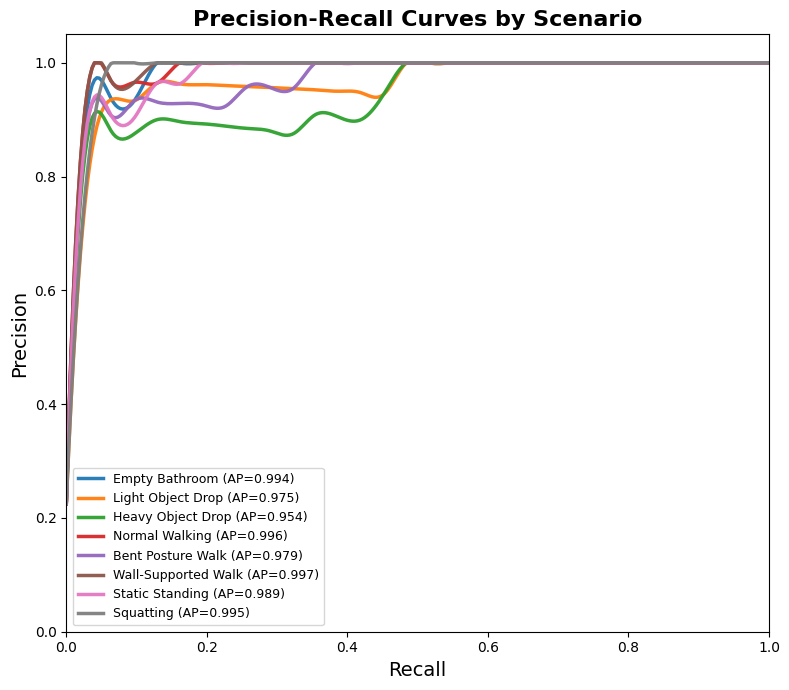

Saved: figs_by_group/pr_by_scenario_smooth.png


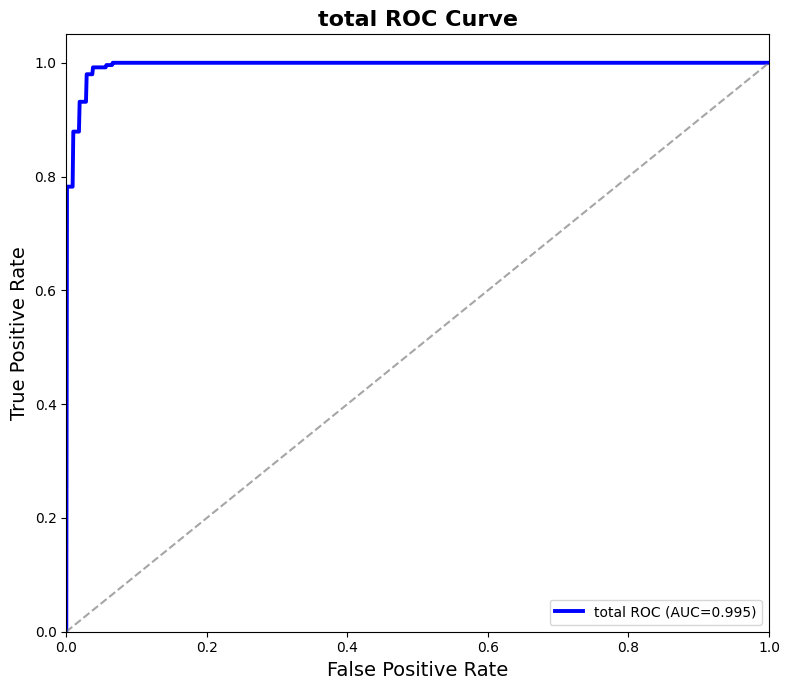

Saved: figs_by_group/total.png


In [35]:
import os
import numpy as np
import torch
from torch.utils.data import Subset, DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 8 scenario names (must align with `groups`)
group_names = [
    "Empty Bathroom",
    "Light Object Drop",
    "Heavy Object Drop",
    "Normal Walking",
    "Bent Posture Walk",
    "Wall-Supported Walk",
    "Static Standing",
    "Squatting"
]

SHOW_IN_NOTEBOOK = True

def _assert_ready():
    assert "modelLSTNtransformer" in globals(), "Please define `modelLSTNtransformer` first."
    assert "base_dataset" in globals(), "Please define `base_dataset` first."
    assert "groups" in globals(), "Please define `groups` (list of index lists) first."
    assert len(group_names) == len(groups) == 8, \
        f"Mismatch in group count: len(groups)={len(groups)}, len(group_names)={len(group_names)}"

def _smooth_xy(x, y, n_points=300, k=3):
    """B-spline smoothing with a safe fallback for short/degenerate curves."""
    x = np.asarray(x); y = np.asarray(y)
    uniq_x, uniq_idx = np.unique(x, return_index=True)
    x_u = uniq_x
    y_u = y[np.sort(uniq_idx)]
    if len(x_u) >= (k + 1):
        try:
            x_new = np.linspace(x_u.min(), x_u.max(), n_points)
            spline = make_interp_spline(x_u, y_u, k=k)
            y_new = spline(x_new)
            y_new = np.clip(y_new, 0.0, 1.0)
            return x_new, y_new
        except Exception:
            return x_u, y_u
    else:
        return x_u, y_u

@torch.inference_mode()
def evaluate_subset(model, subset, batch_size=256):
    loader = DataLoader(
        subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )

    all_preds, all_labels, all_scores = [], [], []

    for batch in loader:
        if isinstance(batch, (list, tuple)):
            xb, yb = batch[0], batch[1]
        elif isinstance(batch, dict):
            xb, yb = batch["x"], batch["y"]
        else:
            raise RuntimeError(f"Unknown batch type: {type(batch)}")

        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        logits = model(xb)  # [B] or [B,1] or [B,2]

        if logits.ndim == 1:
            probs_pos = torch.sigmoid(logits)
            pred = (probs_pos >= 0.5).long()
        elif logits.shape[1] == 1:
            probs_pos = torch.sigmoid(logits.squeeze(1))
            pred = (probs_pos >= 0.5).long()
        else:
            probs = torch.softmax(logits, dim=1)
            probs_pos = probs[:, 1]
            pred = torch.argmax(logits, dim=1)

        all_scores.extend(probs_pos.detach().cpu().numpy())
        all_preds.extend(pred.detach().cpu().numpy())
        all_labels.extend(yb.detach().cpu().numpy())

    all_labels = np.asarray(all_labels)
    all_scores = np.asarray(all_scores)
    all_preds  = np.asarray(all_preds)

    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="binary", zero_division=0)
    rec  = recall_score(all_labels, all_preds, average="binary", zero_division=0)
    f1   = f1_score(all_labels, all_preds, average="binary", zero_division=0)

    return acc, prec, rec, f1, len(all_labels), all_labels, all_scores, all_preds

def run_group_evaluation(show_plots: bool = SHOW_IN_NOTEBOOK):
    _assert_ready()

    model = modelLSTNtransformer.to(device).eval()
    os.makedirs("figs_by_group", exist_ok=True)

    results   = []     # (name, n, acc, prec, rec, f1)
    roc_data  = []     # (name, fpr, tpr, auc)
    pr_data   = []     # (name, rec_curve, prec_curve, AP)

    for k, (idx, name) in enumerate(zip(groups, group_names), start=1):
        subset = Subset(base_dataset, idx)
        acc, prec, rec, f1, n, y_true, y_score, y_pred = evaluate_subset(model, subset)

        results.append((name, n, acc, prec, rec, f1))
        print(f"[{name}] (Group {k}/8) N={n:4d} | Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | F1={f1:.4f}")

        # Compute ROC/PR if both classes appear
        if len(np.unique(y_true)) == 2:
            fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
            roc_auc = auc(fpr, tpr)
            roc_data.append((name, fpr, tpr, roc_auc))

            prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_score, pos_label=1)
            ap = average_precision_score(y_true, y_score, pos_label=1)
            pr_data.append((name, rec_curve, prec_curve, ap))
        else:
            print(f"[{name}] skip ROC/PR (labels contain a single class).")

    # ====== Overall means ======
    if results:
        mean_acc  = np.mean([r[2] for r in results])
        mean_prec = np.mean([r[3] for r in results])
        mean_rec  = np.mean([r[4] for r in results])
        mean_f1   = np.mean([r[5] for r in results])

        Ns = np.array([r[1] for r in results], dtype=float)
        w  = Ns / Ns.sum()
        w_acc  = np.sum(w * np.array([r[2] for r in results]))
        w_prec = np.sum(w * np.array([r[3] for r in results]))
        w_rec  = np.sum(w * np.array([r[4] for r in results]))
        w_f1   = np.sum(w * np.array([r[5] for r in results]))

        print("\n=== Overall (simple mean over 8 scenarios) ===")
        print(f"Acc={mean_acc:.4f} | Prec={mean_prec:.4f} | Rec={mean_rec:.4f} | F1={mean_f1:.4f}")

        print("=== Overall (sample-weighted mean) ===")
        print(f"Acc={w_acc:.4f} | Prec={w_prec:.4f} | Rec={w_rec:.4f} | F1={w_f1:.4f}")

    if len(pr_data) > 0:
        plt.figure(figsize=(8, 7))
        colors = plt.cm.tab10.colors

        for i, (name, rec_curve, prec_curve, ap) in enumerate(pr_data):
            x_plot, y_plot = _smooth_xy(rec_curve, prec_curve, n_points=300, k=3)
            plt.plot(x_plot, y_plot,
                     lw=2.5, alpha=0.95, color=colors[i % len(colors)],
                     label=f"{name} (AP={ap:.3f})")

        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)
        plt.title("Precision-Recall Curves by Scenario", fontsize=16, weight="bold")
        plt.legend(loc="lower left", fontsize=9)
        plt.tight_layout()
        out_pr = "figs_by_group/pr_by_scenario_smooth.png"
        plt.savefig(out_pr, dpi=300)
        if show_plots:
            plt.show()
        plt.close()
        print(f"Saved: {out_pr}")

    if len(roc_data) > 0:
        mean_fpr = np.linspace(0.0, 1.0, 1000)
        tprs_interp = []
        for name, fpr, tpr, roc_auc in roc_data:
            order = np.argsort(fpr)
            fpr_sorted = fpr[order]
            tpr_sorted = tpr[order]
            tpr_interp = np.interp(mean_fpr, fpr_sorted, tpr_sorted)
            tpr_interp[0] = 0.0
            tprs_interp.append(tpr_interp)

        mean_tpr = np.mean(tprs_interp, axis=0)
        mean_tpr[-1] = 1.0
        auc_macro = auc(mean_fpr, mean_tpr)

        plt.figure(figsize=(8, 7))
        plt.plot(mean_fpr, mean_tpr, color="blue", lw=2.8,
                 label=f"total ROC (AUC={auc_macro:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--", lw=1.5, color="gray", alpha=0.7)
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate", fontsize=14)
        plt.ylabel("True Positive Rate", fontsize=14)
        plt.title("total ROC Curve", fontsize=16, weight="bold")
        plt.legend(loc="lower right", fontsize=10)
        plt.tight_layout()
        out_avg_roc = "figs_by_group/total.png"
        plt.savefig(out_avg_roc, dpi=300)
        if show_plots:
            plt.show()
        plt.close()
        print(f"Saved: {out_avg_roc}")


if __name__ == "__main__":
    try:
        run_group_evaluation()
    except AssertionError as e:
        print("Not ready:", e)
